# EDA, Data-cleaning, pre-processing, visualization

##### **Objective**: To explore, visualize, understand, pre-process, encode, split and save the data. The saved piece of data must contain comprehensible, readable, intuitive information (feature names, data types, encodings) and reflect the reality (be interpretable and feature- and time-consistent).

---

## Import libraries and functions

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from utils import (
    get_NA_info, date_consistency, target_info, plot_by_time, plot_the_features_against_target, 
    pick_winsorization_thresholds, get_categoric_info
)

## Import and explore the data

In [ ]:
# constants
data_folder_path = "data"
TARGET = "PM2.5"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# import data
df = pd.read_csv(os.path.join(data_folder_path, 'raw', "PRSA_Data_Aotizhongxin_20130301-20170228.csv"), index_col=0)
df.head()

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
No                                                                       
1   2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2   2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
3   2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
4   2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
5   2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

      PRES  DEWP  RAIN   wd  WSPM       station  
No                                               
1   1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
2   1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
3   1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
4   1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
5   1025.2 -19.5   0.0    N   2.0  Aotizhongxin

## Renaming / Removing extra columns

In [4]:
df['station'].value_counts()

station
Aotizhongxin    35064
Name: count, dtype: int64

The `station`'s value is the same across all the rows, doesn't bear valuable information for the model; constant. All other features look useful and have appropriate and comprehensive names.

In [5]:
df.drop(columns=["station"], inplace=True)
df.head()

year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
No                                                                       
1   2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
2   2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
3   2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
4   2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
5   2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

      PRES  DEWP  RAIN   wd  WSPM  
No                                 
1   1023.0 -18.8   0.0  NNW   4.4  
2   1023.2 -18.2   0.0    N   4.7  
3   1023.5 -18.2   0.0  NNW   5.6  
4   1024.5 -19.4   0.0   NW   3.1  
5   1025.2 -19.5   0.0    N   2.0

## Dividing features into object and numerical

In [6]:
object_features = [feat for feat in df.columns if df[feat].dtype == "O"]
display("Object features:", object_features)

numerical_features = [feat for feat in df.columns if feat not in object_features]
display("Numeric features:", numerical_features)

'Object features:'

['wd']

'Numeric features:'

['year',
 'month',
 'day',
 'hour',
 'PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'CO',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'WSPM']

## Missing values overview

In [7]:
# print object feature nulls
print("Object feature nulls:")

object_nulls = get_NA_info(df, object_features)
object_nulls

Object feature nulls:


Feature  NA Count  Total Count  NA Percentage
0      wd        81        35064       0.231006

In [8]:
# print numeric feature nulls
print("Numeric feature nulls:")

numerical_nulls = get_NA_info(df, numerical_features)
numerical_nulls

Numeric feature nulls:


Feature  NA Count  Total Count  NA Percentage
0       CO      1776        35064       5.065024
1       O3      1719        35064       4.902464
2      NO2      1023        35064       2.917522
3      SO2       935        35064       2.666553
4    PM2.5       925        35064       2.638033
5     PM10       718        35064       2.047684
6     TEMP        20        35064       0.057039
7     PRES        20        35064       0.057039
8     DEWP        20        35064       0.057039
9     RAIN        20        35064       0.057039
10    WSPM        14        35064       0.039927

In [9]:
print(f"Highest missing count per feature: {max(object_nulls['NA Percentage'].values[0], numerical_nulls['NA Percentage'].values[0]):.3f}%")
print(f"Overall missing component: {object_nulls['NA Percentage'].sum() + numerical_nulls['NA Percentage'].sum():.3f}%")

Highest missing count per feature: 5.065%
Overall missing component: 20.736%


The null count is assessed as significant and may introduce bias in the a

## Train-test split

In order to assess the future model properly including its weaknesses and the way it behaves on unseen data, we need to prevent data leakage. It is important to divide the data into train and test sets and only use the train for any imputations and further inference. It is only this way that it may act as truly unseen data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, df[TARGET], test_size=0.2, shuffle=False, random_state=RANDOM_SEED)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (28051, 16)
Test shape: (7013, 16)


In [11]:
display(X_train['year'].value_counts())
display(X_test['year'].value_counts())

year
2014    8760
2015    8760
2013    7344
2016    3187
Name: count, dtype: int64

year
2016    5597
2017    1416
Name: count, dtype: int64

The dataframe is sorted to ensure no time disruptions. Model will be seen in action dealing with the ongoing trends of 2016 (partially present in train) as well as new 2017 (only present in test).

In [12]:
# Creating separate dataframes for convenient analysis
df_train = X_train.copy()
df_train[TARGET] = y_train

print("df train:")
display(df_train.head(2))

df_test  = X_test.copy()
df_test[TARGET]  = y_test

print("df test:")
display(df_test.head(2))

df train:


year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  \
No                                                                             
1   2013      3    1     0    4.0   4.0  4.0  7.0  300.0  77.0  -0.7  1023.0   
2   2013      3    1     1    8.0   8.0  4.0  7.0  300.0  77.0  -1.1  1023.2   

    DEWP  RAIN   wd  WSPM  
No                         
1  -18.8   0.0  NNW   4.4  
2  -18.2   0.0    N   4.7

df test:


year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP  \
No                                                                         
28052  2016      5   12    19   10.0  36.0  2.0  18.0  300.0  89.0  20.3   
28053  2016      5   12    20   26.0  52.0  2.0  30.0  400.0  66.0  17.4   

         PRES  DEWP  RAIN   wd  WSPM  
No                                    
28052  1011.7  -5.6   0.0  NNW   2.2  
28053  1012.6   0.1   0.0  NNW   0.6

## Check for data consistency

In [13]:
df.dtypes

year       int64
month      int64
day        int64
hour       int64
PM2.5    float64
PM10     float64
SO2      float64
NO2      float64
CO       float64
O3       float64
TEMP     float64
PRES     float64
DEWP     float64
RAIN     float64
wd        object
WSPM     float64
dtype: object

Data types are consistent with the given natures. No actions required.

### Row duplicates

In [14]:
duplicate_rows_train = df_train[df_train.duplicated()]
duplicate_rows_test = df_train[df_train.duplicated()]

print("Duplicate in train:")
display(duplicate_rows_train)

print("Duplicate in test:")
display(duplicate_rows_test)

Duplicate in train:


Empty DataFrame
Columns: [year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM]
Index: []

Duplicate in test:


Empty DataFrame
Columns: [year, month, day, hour, PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM]
Index: []

### Date consistency

Does the dataset have inconsistent time intervals?


time_diff
0 days 01:00:00    28050
Name: count, dtype: int64

----------------------------------------------
Time gaps analysis plotted


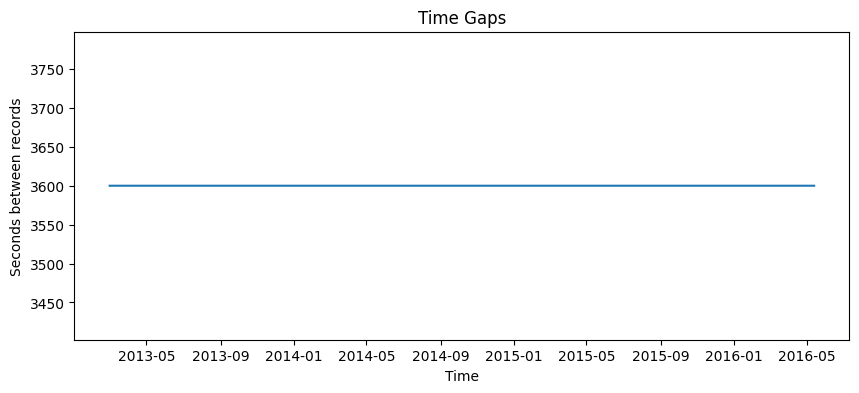

In [15]:
date_consistency(df_train, df_train['year'], df_train['month'], df_train['day'], df_train['hour'])

Does the dataset have inconsistent time intervals?


time_diff
0 days 01:00:00    7012
Name: count, dtype: int64

----------------------------------------------
Time gaps analysis plotted


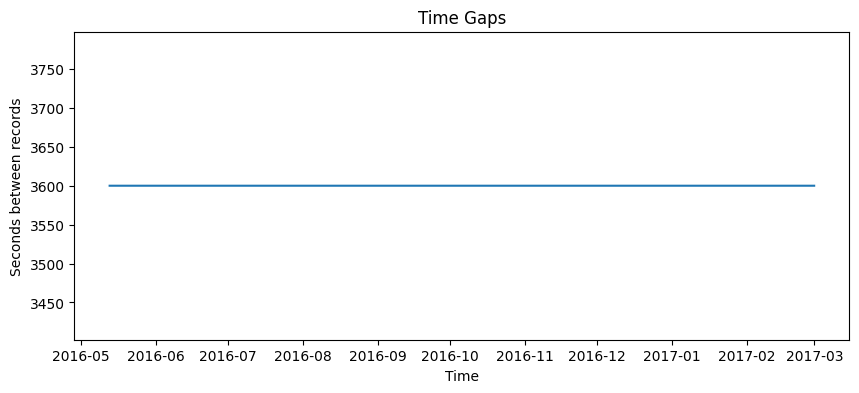

In [16]:
date_consistency(df_test, df_test['year'], df_test['month'], df_test['day'], df_test['hour'])

No time gaps found. Consistent.

### Categoric consistency

In [17]:
for col in object_features:
    print(f"{col}'s unique:", df[col].unique())

wd's unique: ['NNW' 'N' 'NW' 'NNE' 'ENE' 'E' 'NE' 'W' 'SSW' 'WSW' 'SE' 'WNW' 'SSE'
 'ESE' 'S' 'SW' nan]


Consistent. There is no need to use fuzzy matching, look for typos or erroneous entries. The categoric column is the only one and its 12 unique values are easy to inspect visually; they reflect 12 standard compass directions.

### Target consistency

Unique target values:


counts     %
PM2.5              
9.0     600.0  0.02
10.0    590.0  0.02
12.0    576.0  0.02
11.0    570.0  0.02
8.0     563.0  0.02
...       ...   ...
505.0     1.0  0.00
565.0     1.0  0.00
587.0     1.0  0.00
462.0     1.0  0.00
NaN     925.0  2.64

[546 rows x 2 columns]

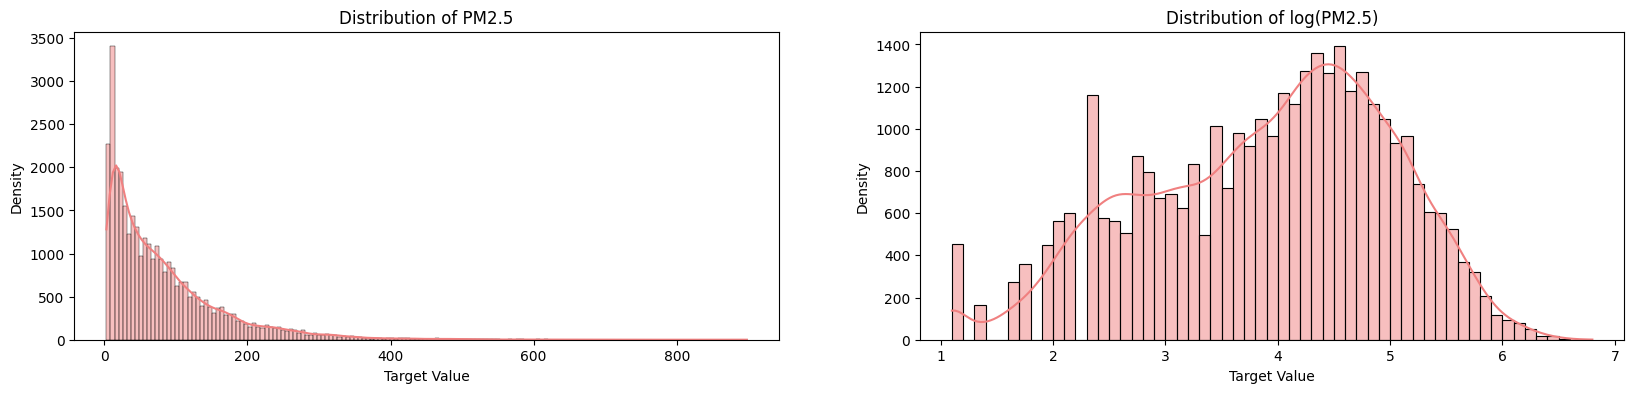

In [18]:
target_info(df, TARGET, "log")

Most values cluster around smaller numbers going down exponentially in its quantity of representations.

#### Is target's imbalance a reflection of reality or underrepresented data?

In [19]:
datetime_index_train = pd.to_datetime(df_train[['year', 'month', 'day', 'hour']])
df_train.index = datetime_index_train

datetime_index_test = pd.to_datetime(df_test[['year', 'month', 'day', 'hour']])
df_test.index = datetime_index_test

def encode_season(month):
        if month in [12, 1, 2]:
            return 1  # Winter
        elif month in [3, 4, 5]:
            return 2  # Spring
        elif month in [6, 7, 8]:
            return 3  # Summer
        elif month in [9, 10, 11]:
            return 4  # Autumn

# Apply season encoding
df_train['season'] = df_train.index.month.map(encode_season)
df_test['season'] = df_test.index.month.map(encode_season)

df_train['is_weekend'] = df_train.index.dayofweek.map(lambda x: 1 if x >= 5 else 0)
df_test['is_weekend'] = df_test.index.dayofweek.map(lambda x: 1 if x >= 5 else 0)

df_train['dayofweek'] = df_train.index.dayofweek
df_test['dayofweek'] = df_test.index.dayofweek

print("Train:")
display(df_train.head(2))

print("Test:")
display(df_test.head(2))

Train:


year  month  day  hour  PM2.5  PM10  SO2  NO2     CO  \
2013-03-01 00:00:00  2013      3    1     0    4.0   4.0  4.0  7.0  300.0   
2013-03-01 01:00:00  2013      3    1     1    8.0   8.0  4.0  7.0  300.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  season  \
2013-03-01 00:00:00  77.0  -0.7  1023.0 -18.8   0.0  NNW   4.4       2   
2013-03-01 01:00:00  77.0  -1.1  1023.2 -18.2   0.0    N   4.7       2   

                     is_weekend  dayofweek  
2013-03-01 00:00:00           0          4  
2013-03-01 01:00:00           0          4

Test:


year  month  day  hour  PM2.5  PM10  SO2   NO2     CO  \
2016-05-12 19:00:00  2016      5   12    19   10.0  36.0  2.0  18.0  300.0   
2016-05-12 20:00:00  2016      5   12    20   26.0  52.0  2.0  30.0  400.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  season  \
2016-05-12 19:00:00  89.0  20.3  1011.7  -5.6   0.0  NNW   2.2       2   
2016-05-12 20:00:00  66.0  17.4  1012.6   0.1   0.0  NNW   0.6       2   

                     is_weekend  dayofweek  
2016-05-12 19:00:00           0          3  
2016-05-12 20:00:00           0          3

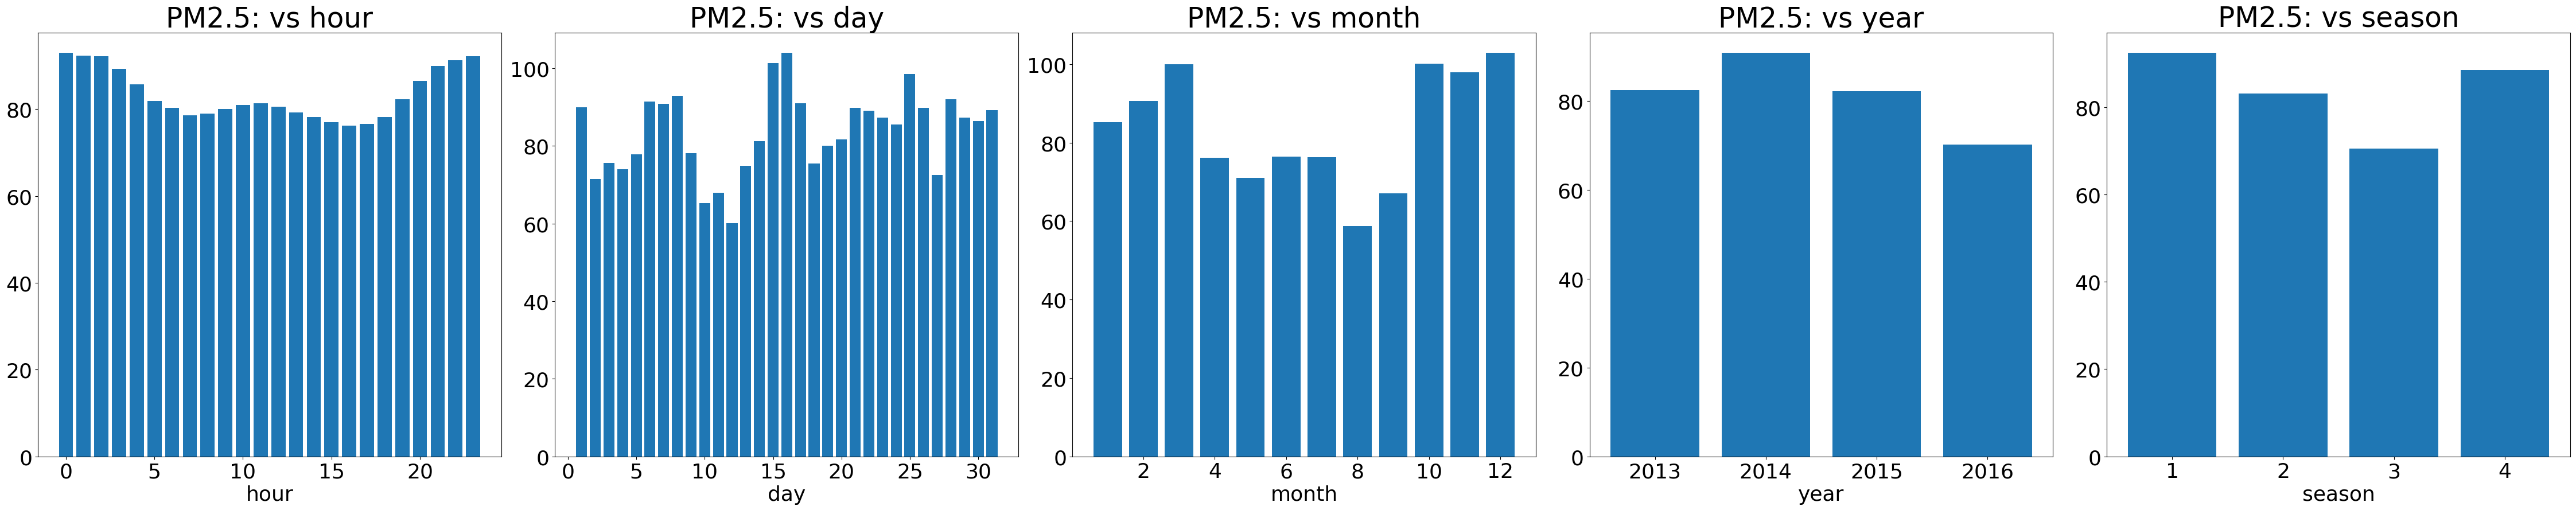

In [20]:
plot_by_time(TARGET, 
            df_train[TARGET], {
            'hour': df_train.index.hour, 'day': df_train.index.day, 'month': df_train.index.month, 'year': df_train.index.year, 'season': df_train['season']},
            per_plot_width=9,
            per_plot_height=9,
            title_font_size=35,
            tick_font_size=26
            )

#### Are target values always underrepresented in the middle of the day?

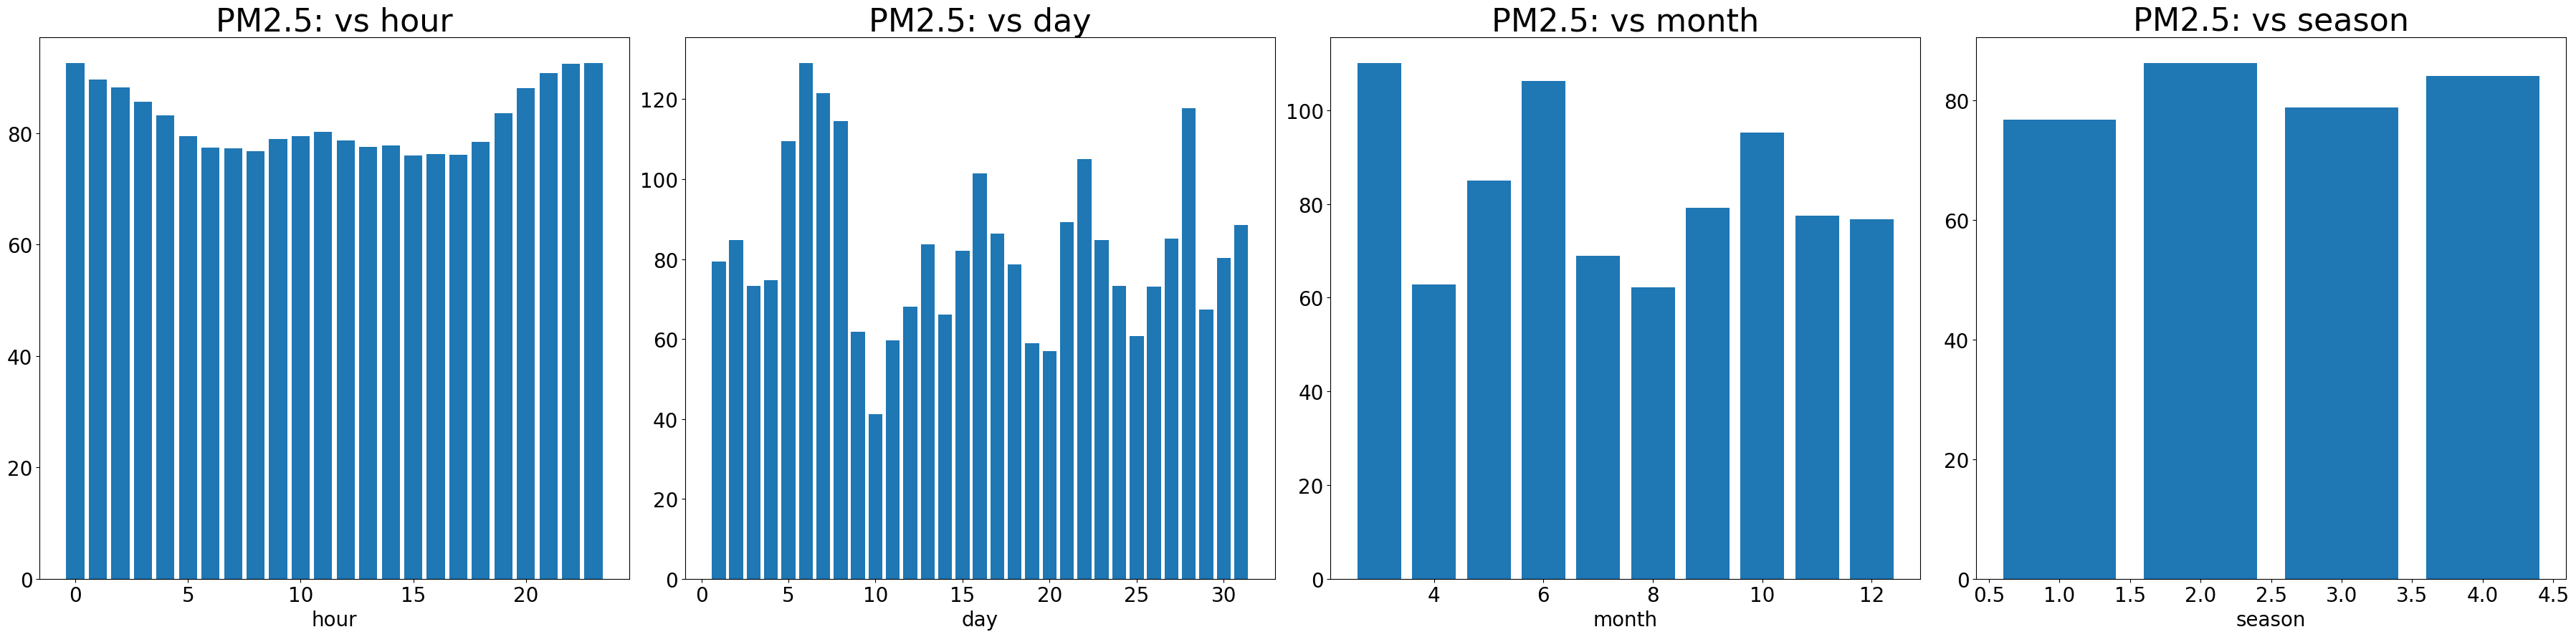

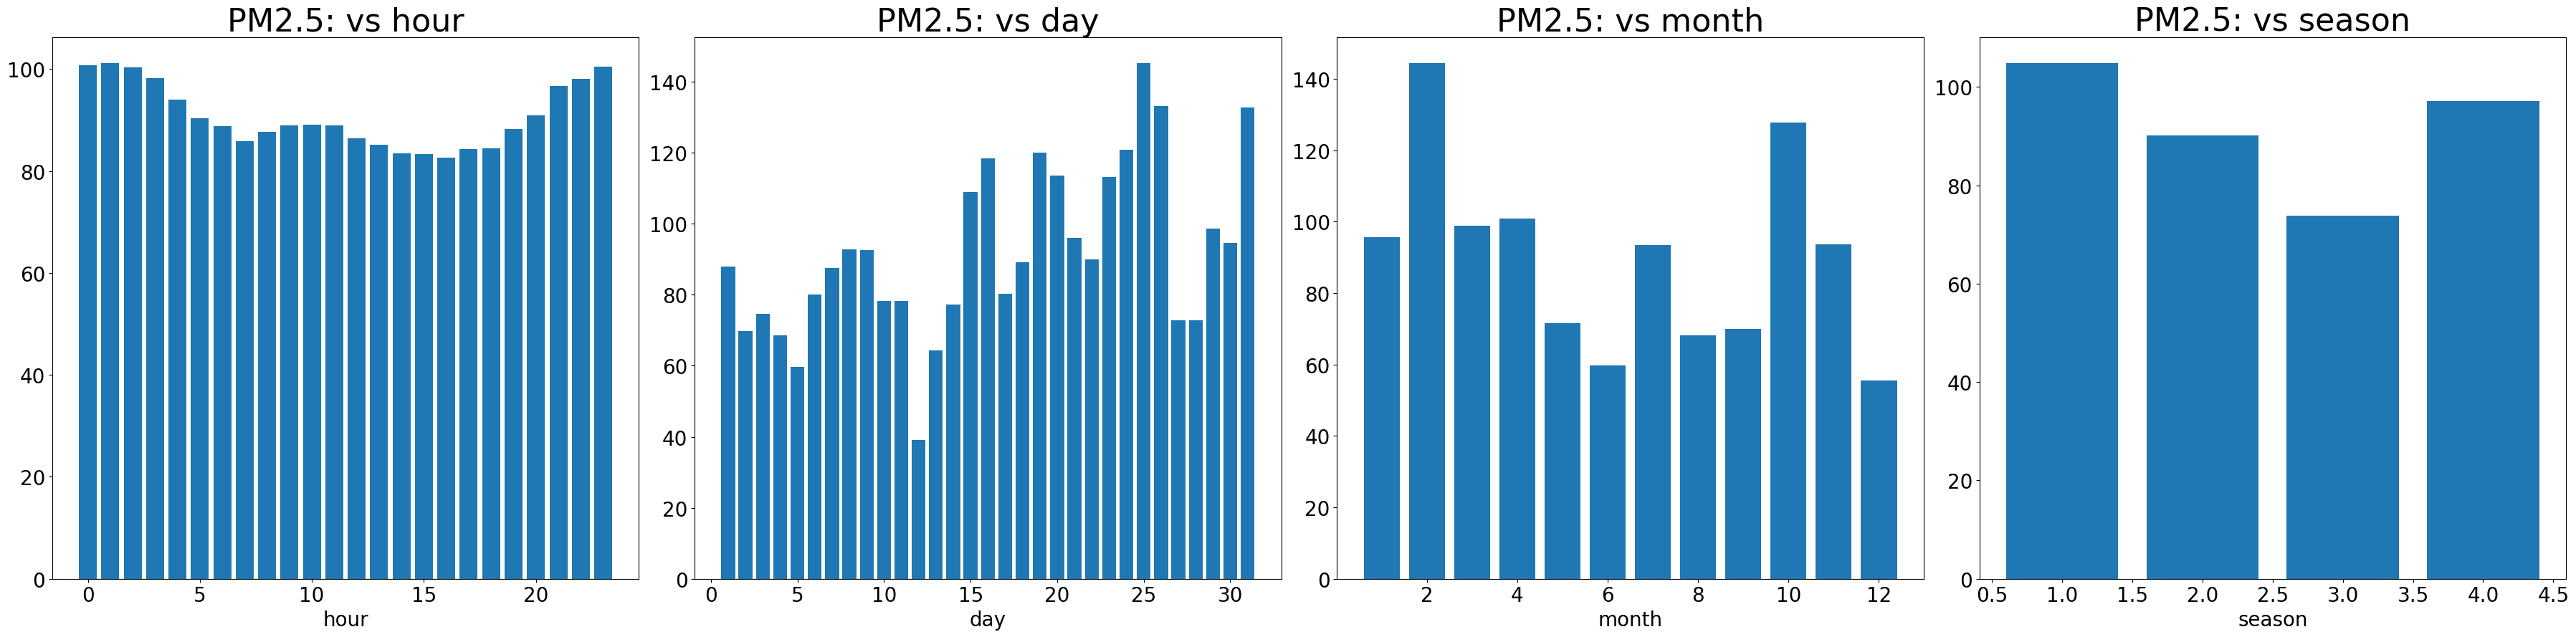

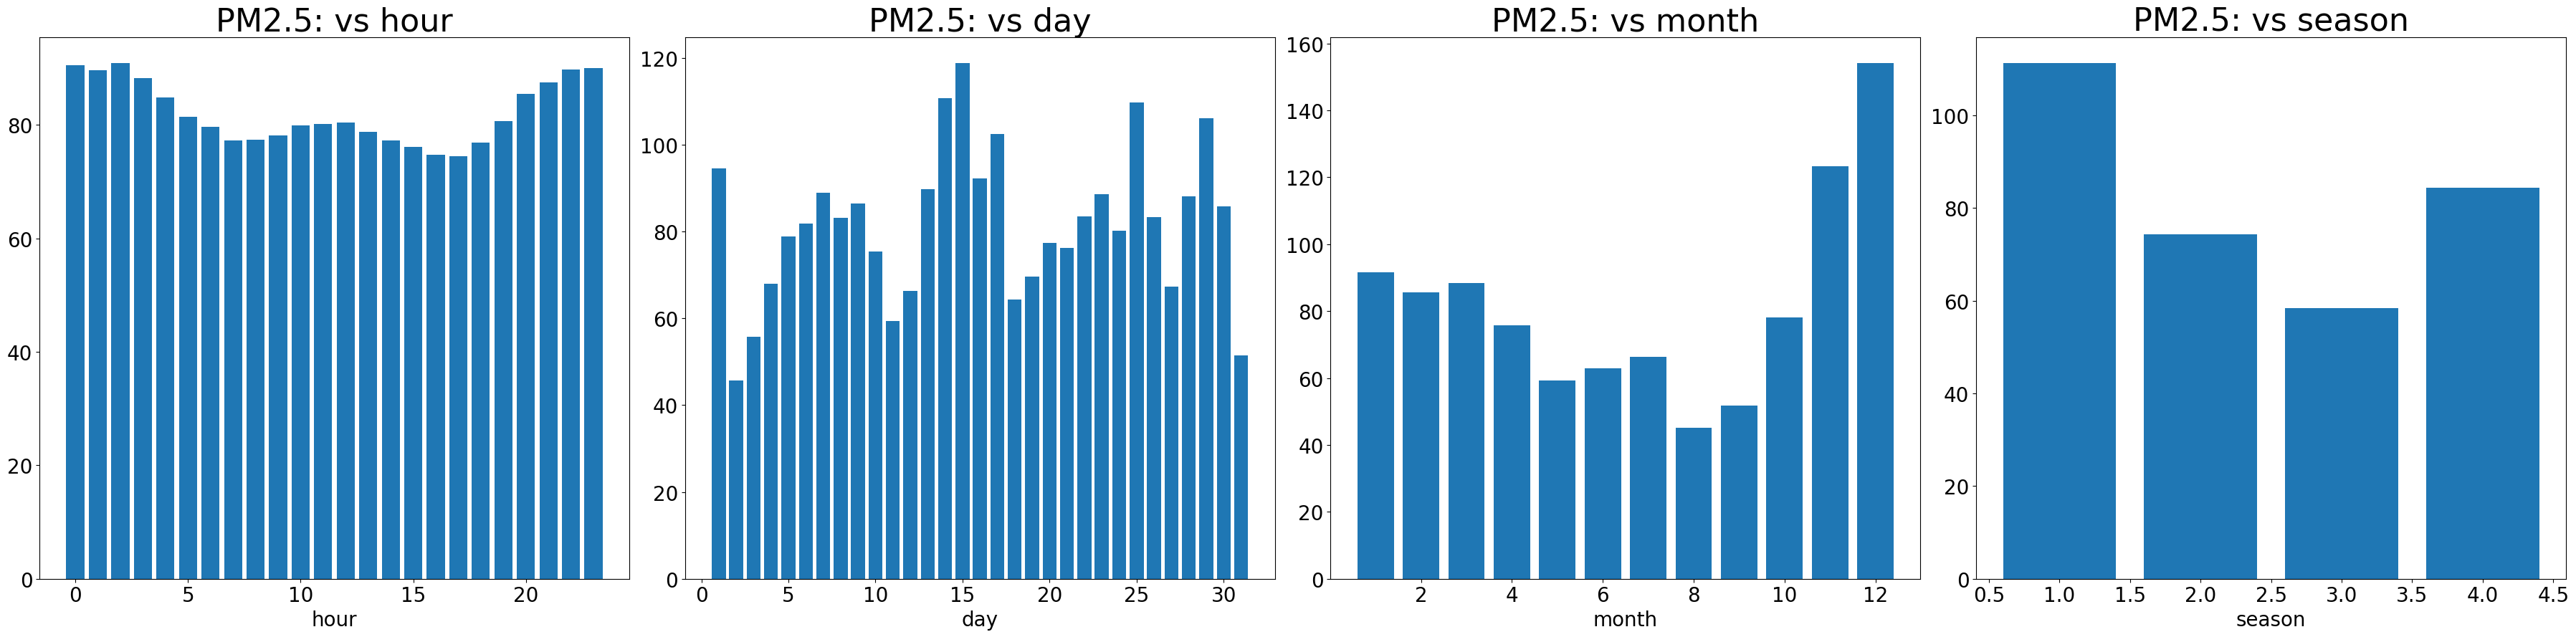

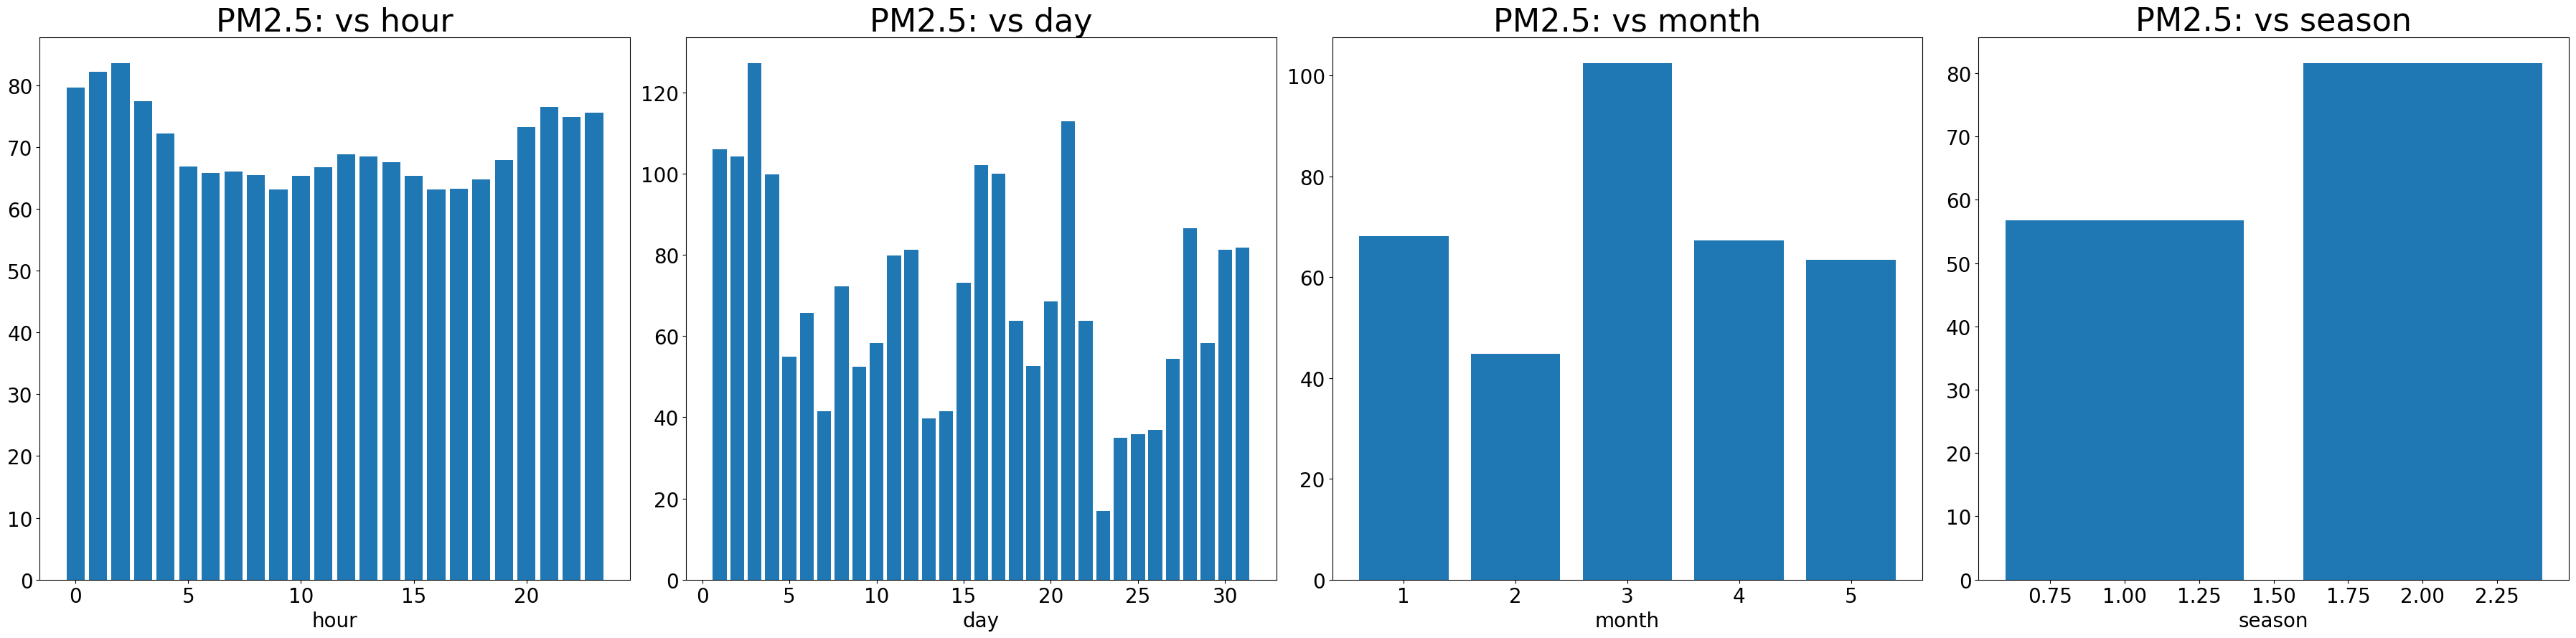

In [21]:
for yr in [2013, 2014, 2015, 2016]:
    year_filtered_df = df_train[df_train.index.year == yr]
    plot_by_time(TARGET, 
                year_filtered_df[TARGET], {
                'hour': year_filtered_df.index.hour, 'day': year_filtered_df.index.day, 'month': year_filtered_df.index.month, 'season': df_train['season']},
                per_plot_width=9,
                per_plot_height=9,
                title_font_size=32,
                tick_font_size=20
                )

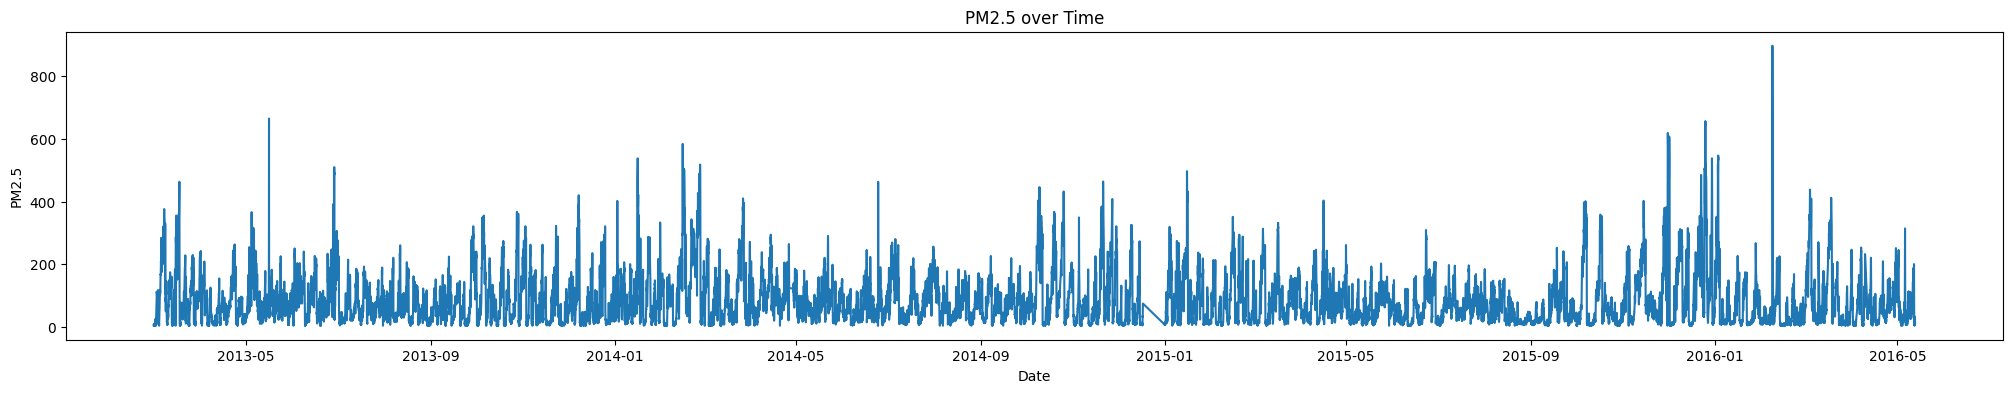

In [22]:
fig = plt.figure(figsize=(25,4))
sns.lineplot(x=df_train.index, y=df_train[TARGET])
plt.title(f'{TARGET} over Time')
plt.ylabel(f'{TARGET}')
plt.xlabel('Date')

plt.show()

The imbalance is real and systematic. The pollution is at its highest at night, up to the early morning. Only the middle part of the day carries smaller values. The tendency is most likely towards taking care of people's health while they are in the city at work (especially on Monday) or going out during the day. This makes each day represent two high and one lower trend, hence the quantity of the larger data points. So this is not sampling bias, but a natural skew in the problem.

#### Addressing the imbalance

We may not apply under- or oversampling techniques due to being dependent on time consistency. Neither can we stratify, but the data is clearly going to be biased towards lower values. Thus, the focus must be to make this trend clear for the model itself:

In [23]:
df_train['is_working_time'] = df_train['hour'].apply(lambda x: 1 if x >= 6 and x <= 18 else 0)
df_test['is_working_time'] = df_test['hour'].apply(lambda x: 1 if x >= 6 and x <= 18 else 0)

print("Train:")
display(df_train.tail(3))

print("Test:")
display(df_test.tail(3))

Train:


year  month  day  hour  PM2.5  PM10  SO2   NO2     CO  \
2016-05-12 16:00:00  2016      5   12    16    5.0   5.0  2.0   8.0  100.0   
2016-05-12 17:00:00  2016      5   12    17   17.0  17.0  2.0  10.0  200.0   
2016-05-12 18:00:00  2016      5   12    18   10.0  16.0  3.0  13.0  200.0   

                        O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  season  \
2016-05-12 16:00:00   99.0  21.1  1010.0  -4.2   0.0  NNW   4.3       2   
2016-05-12 17:00:00  100.0  21.4  1010.4  -3.9   0.0    N   3.5       2   
2016-05-12 18:00:00   98.0  21.3  1010.9  -5.6   0.0  NNW   3.9       2   

                     is_weekend  dayofweek  is_working_time  
2016-05-12 16:00:00           0          3                1  
2016-05-12 17:00:00           0          3                1  
2016-05-12 18:00:00           0          3                1

Test:


year  month  day  hour  PM2.5  PM10   SO2   NO2     CO  \
2017-02-28 21:00:00  2017      2   28    21   16.0  37.0  10.0  66.0  700.0   
2017-02-28 22:00:00  2017      2   28    22   21.0  44.0  12.0  87.0  700.0   
2017-02-28 23:00:00  2017      2   28    23   19.0  31.0  10.0  79.0  600.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  season  \
2017-02-28 21:00:00  58.0  10.8  1014.2 -13.3   0.0   NW   1.1       1   
2017-02-28 22:00:00  35.0  10.5  1014.4 -12.9   0.0  NNW   1.2       1   
2017-02-28 23:00:00  42.0   8.6  1014.1 -15.9   0.0  NNE   1.3       1   

                     is_weekend  dayofweek  is_working_time  
2017-02-28 21:00:00           0          1                0  
2017-02-28 22:00:00           0          1                0  
2017-02-28 23:00:00           0          1                0

## Visualize numeric columns, check for outliers

Before dealing with missing values, we need to make sure there are no outliers to harm missingness predictions. For better understanding, the nulls are being temporarily imputed with a simple median strategy. All the pre-imputed values are going to appear as red dots on the plots to take the trends of their absence in account, as well as to ensure no extreme imputed values were  treated as outliers.

In [24]:
df_train_imputed = df_train[numerical_features].copy()
imputed_masks = df_train_imputed.isna()
df_train_imputed = df_train_imputed.fillna(df_train_imputed.median())

In [25]:
get_NA_info(df_train_imputed, numerical_features) # make sure all nulls are handled

No missing values are found in the dataframe


[]

##### Visualizing the numeric

year


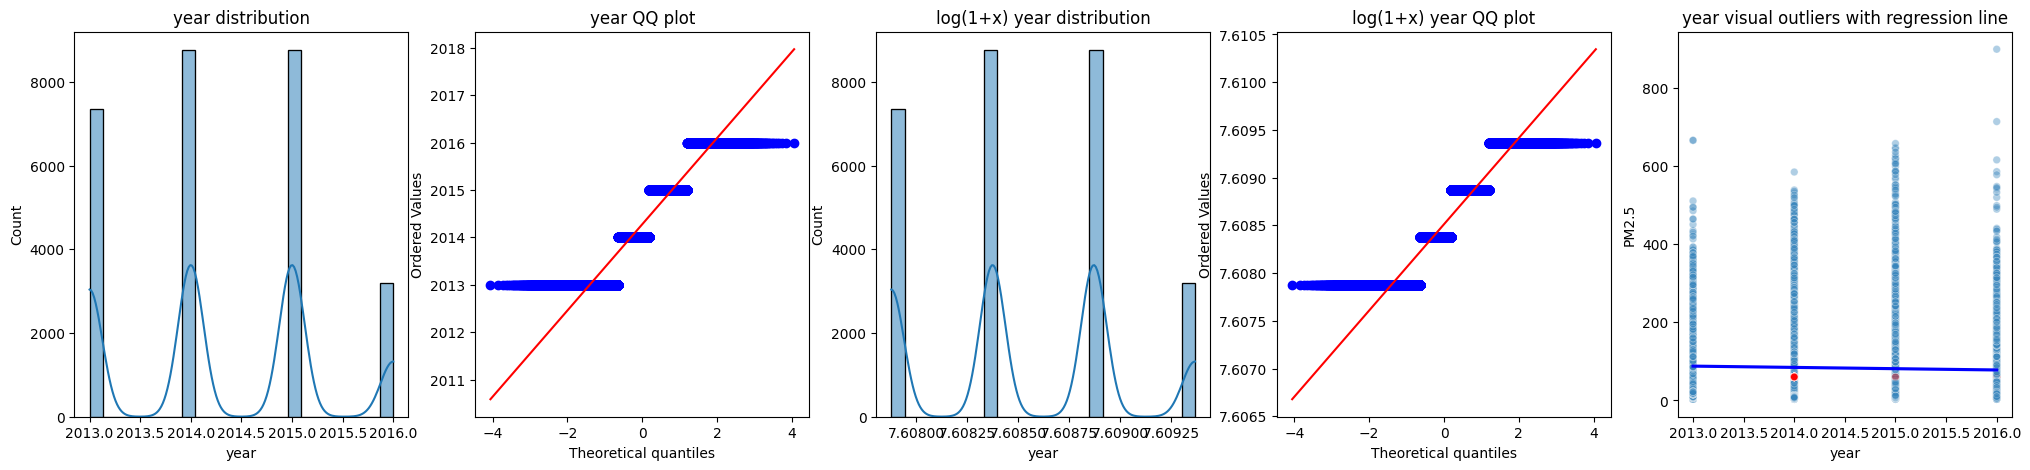

month


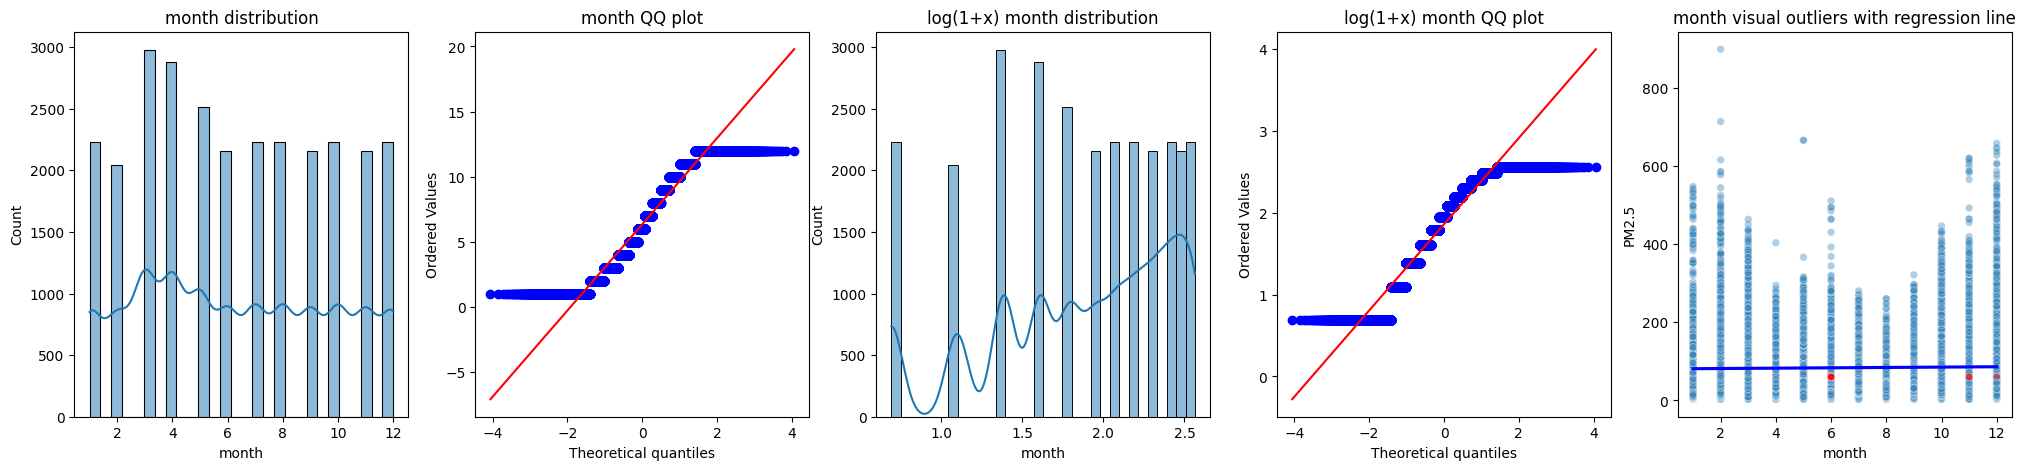

day


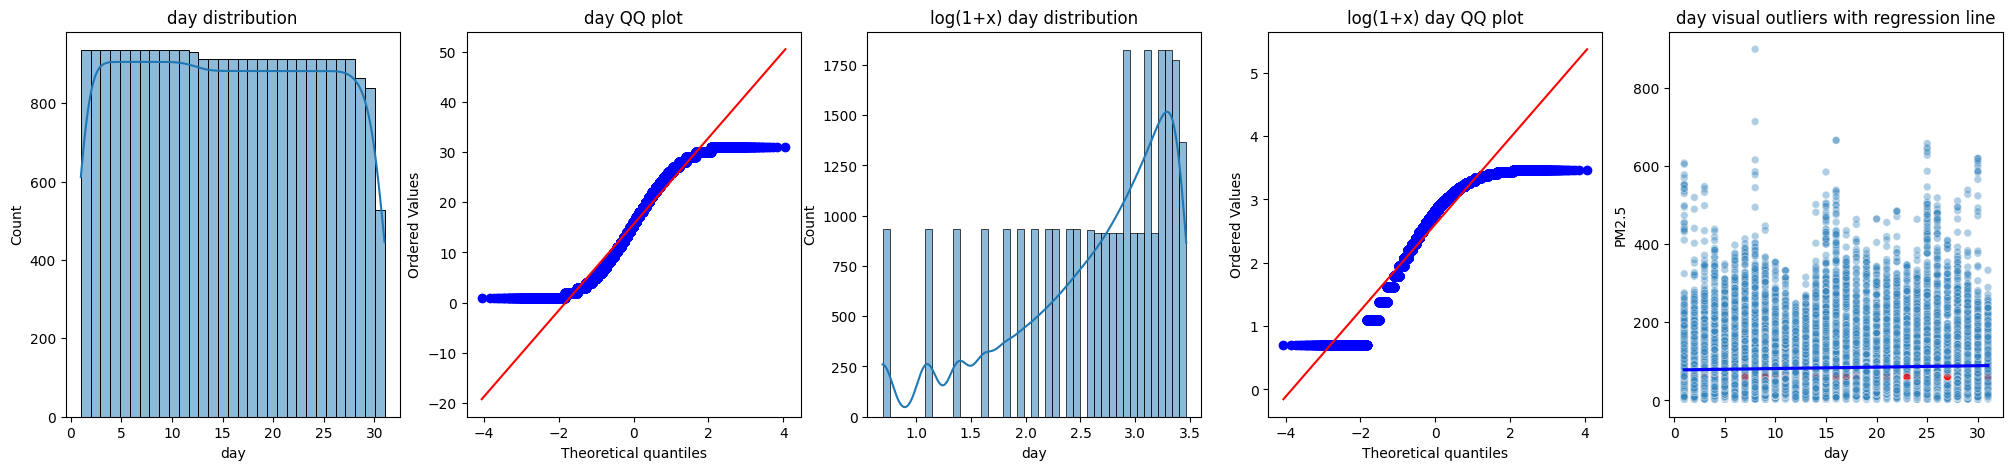

hour


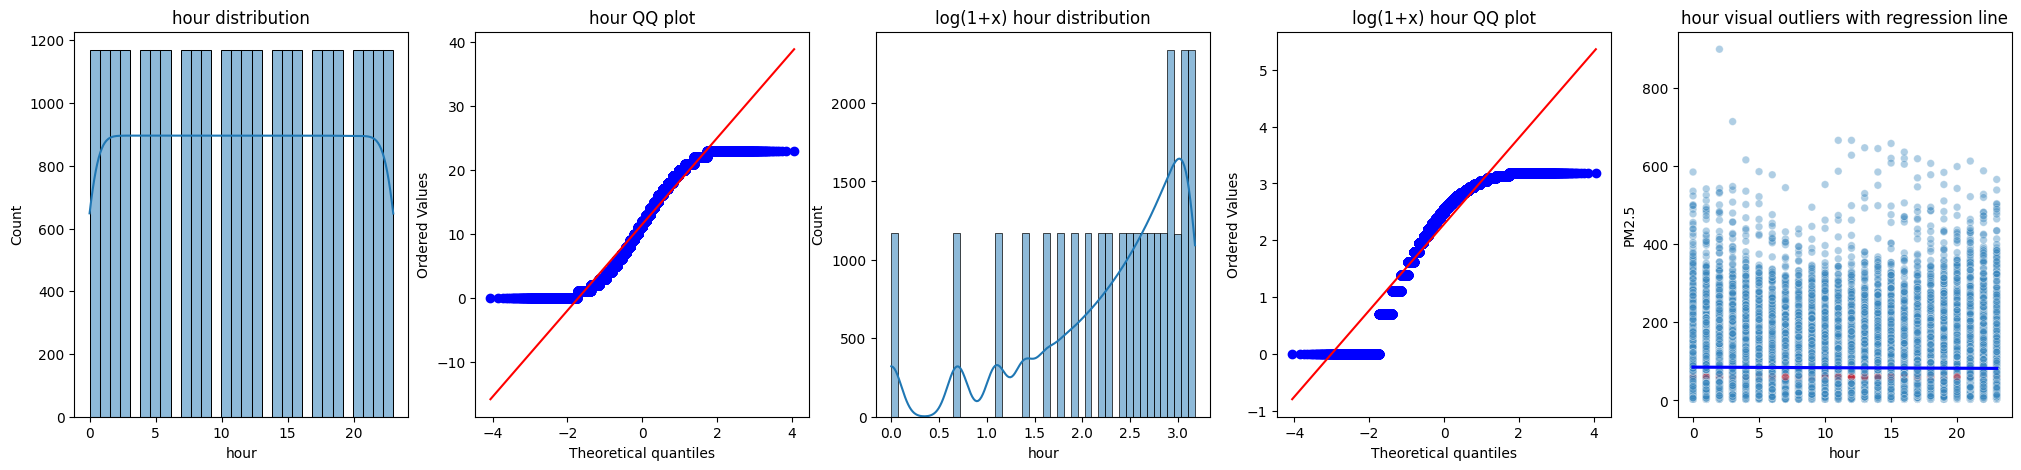

PM2.5


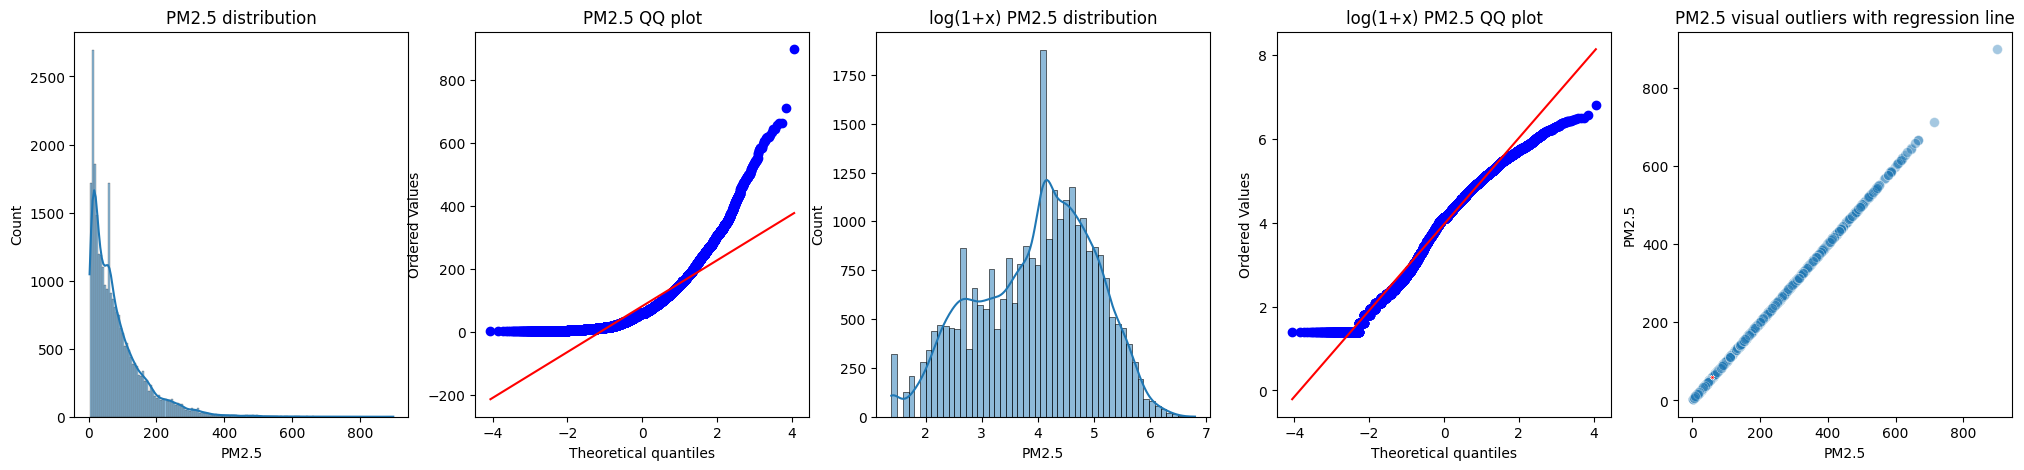

PM10


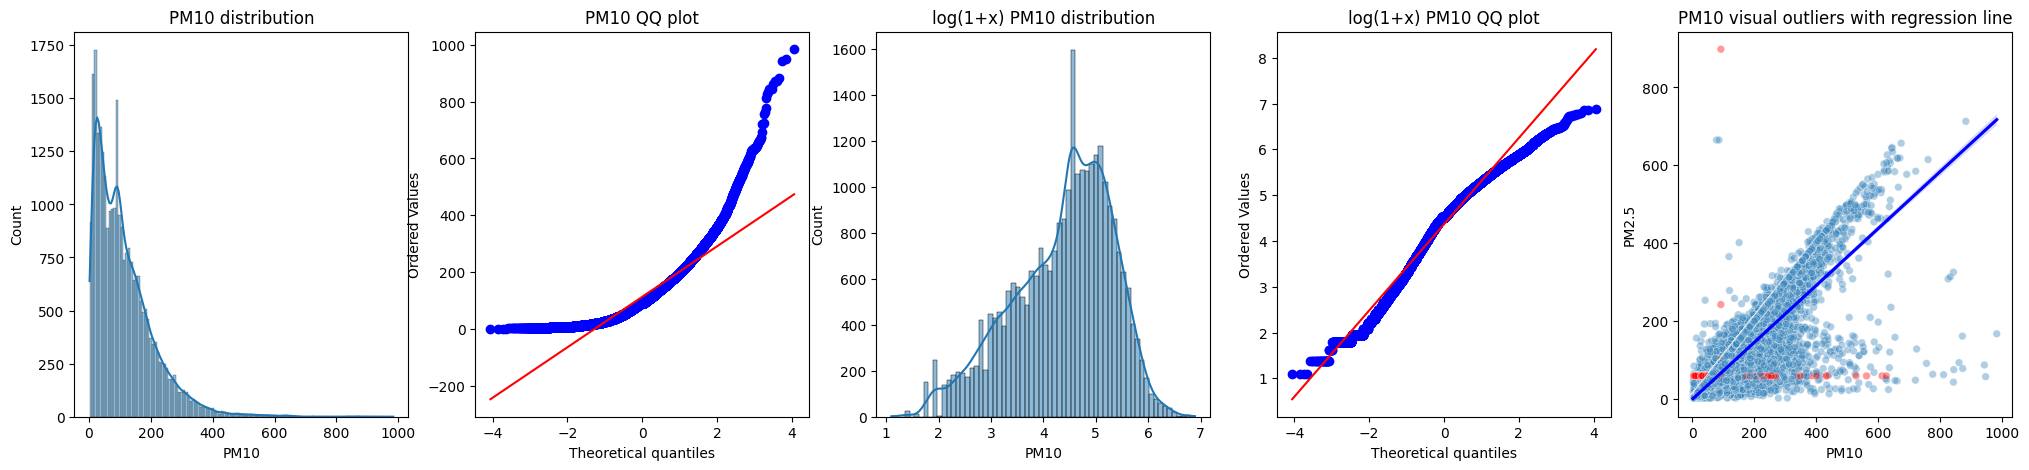

SO2


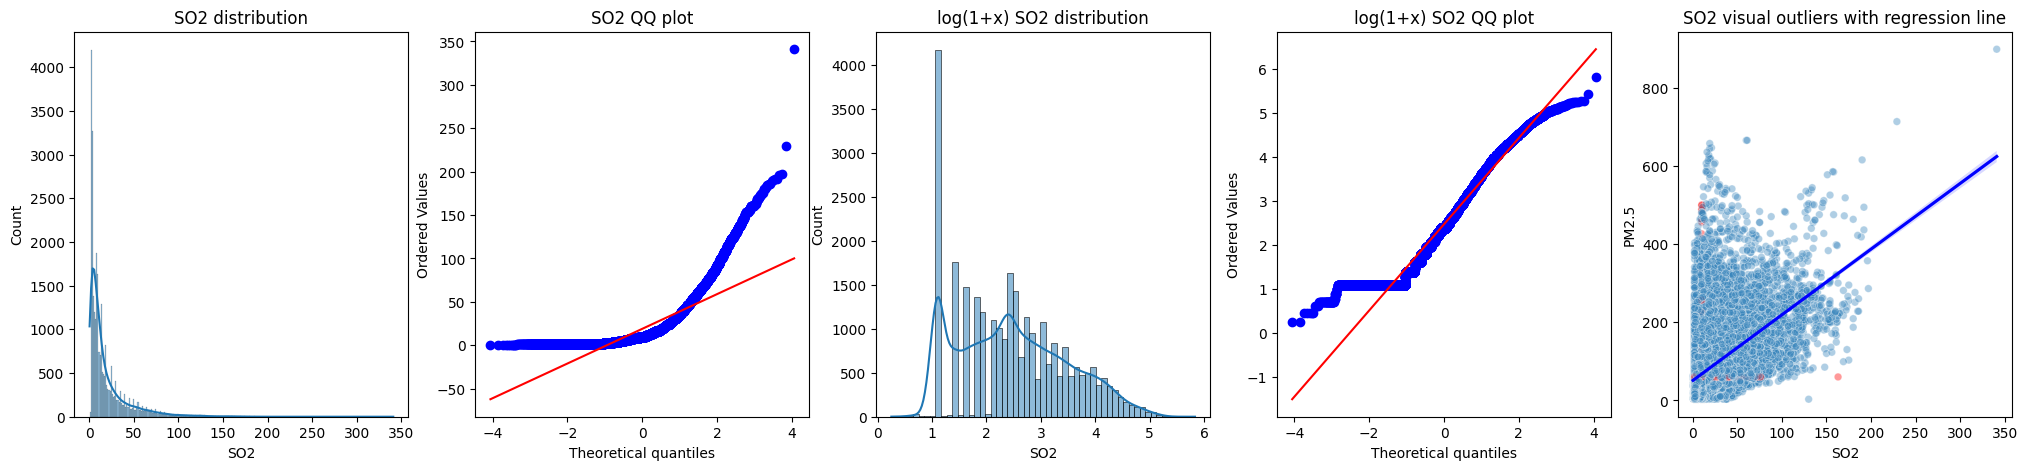

NO2


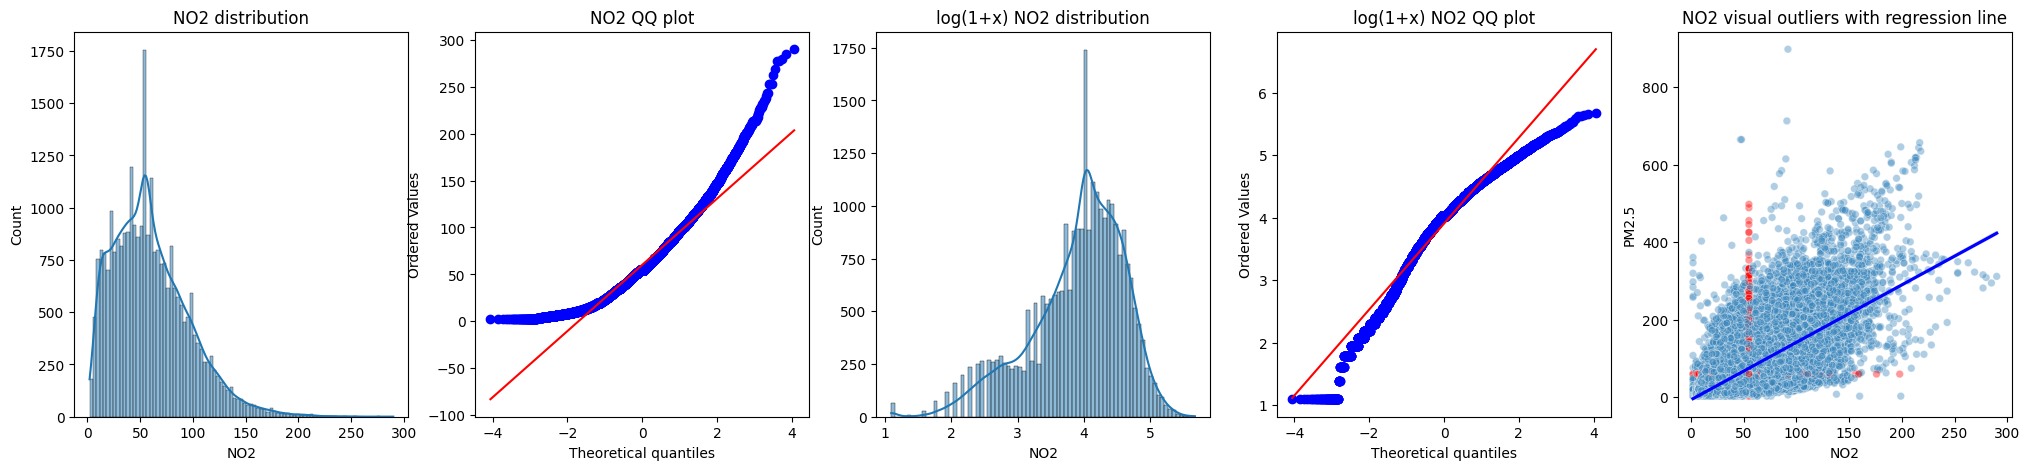

CO


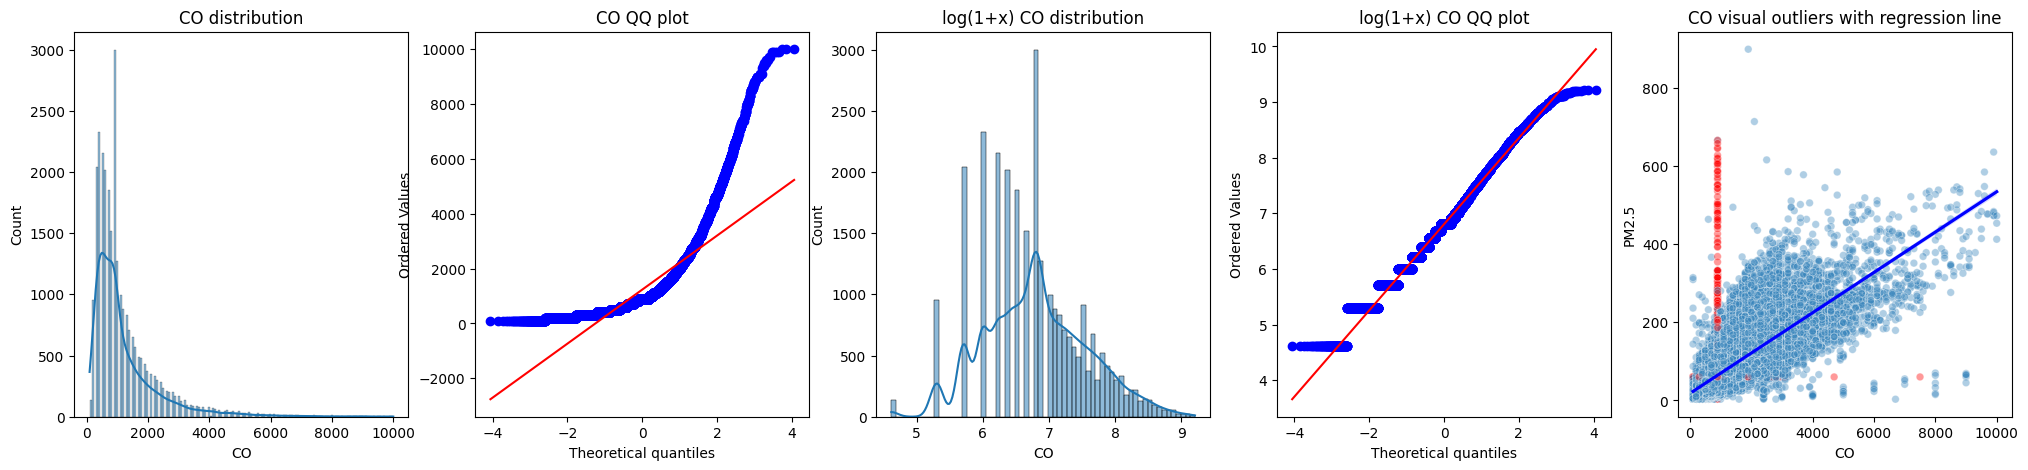

O3


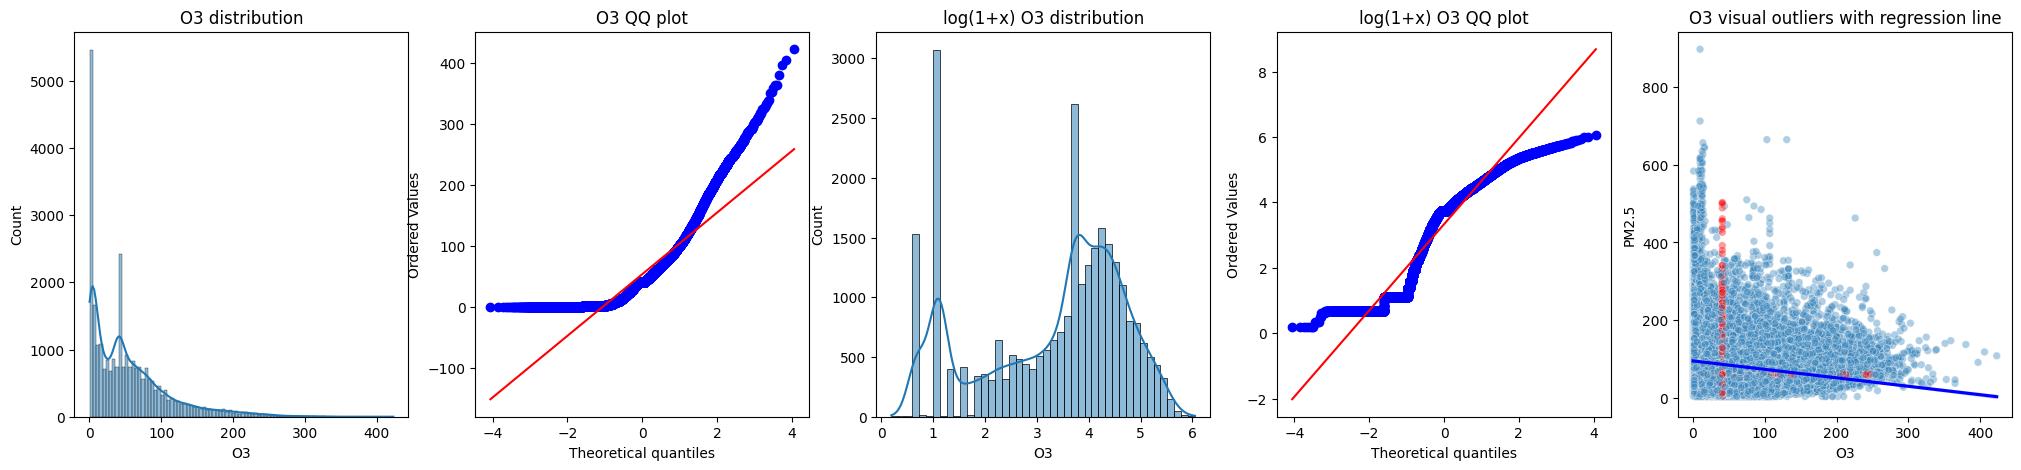

TEMP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


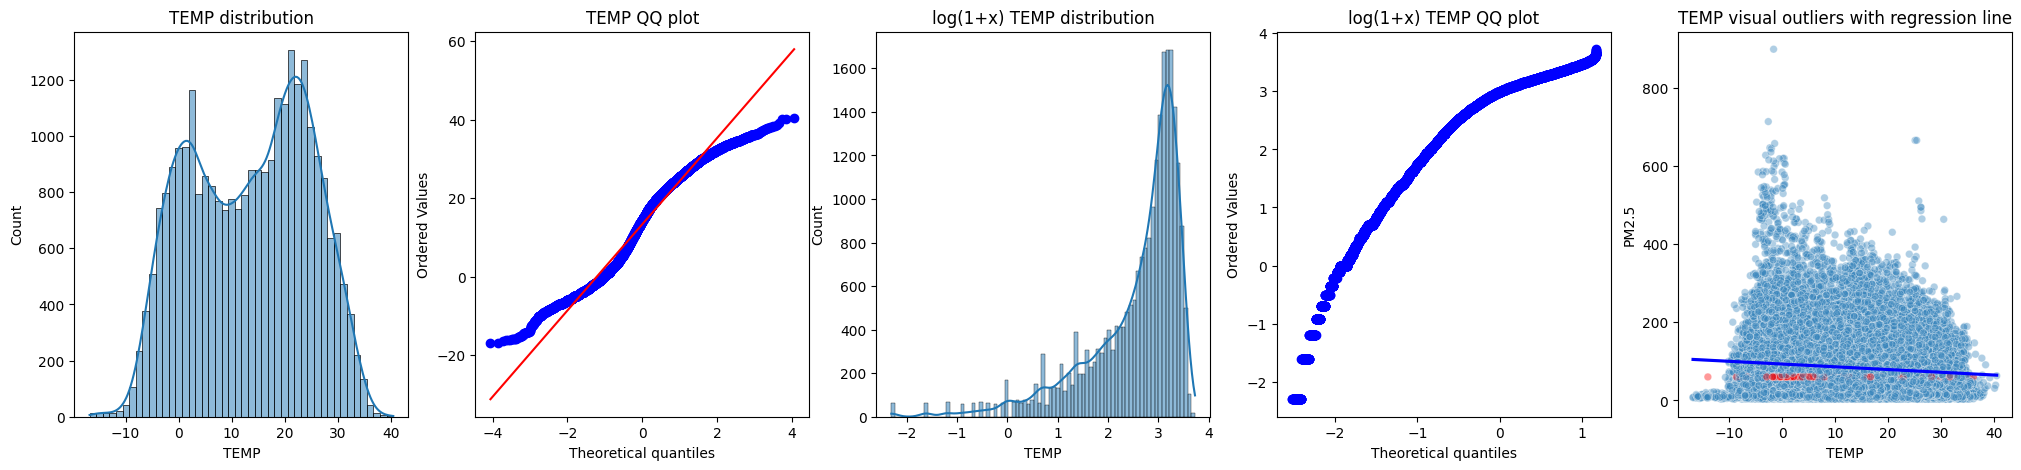

PRES


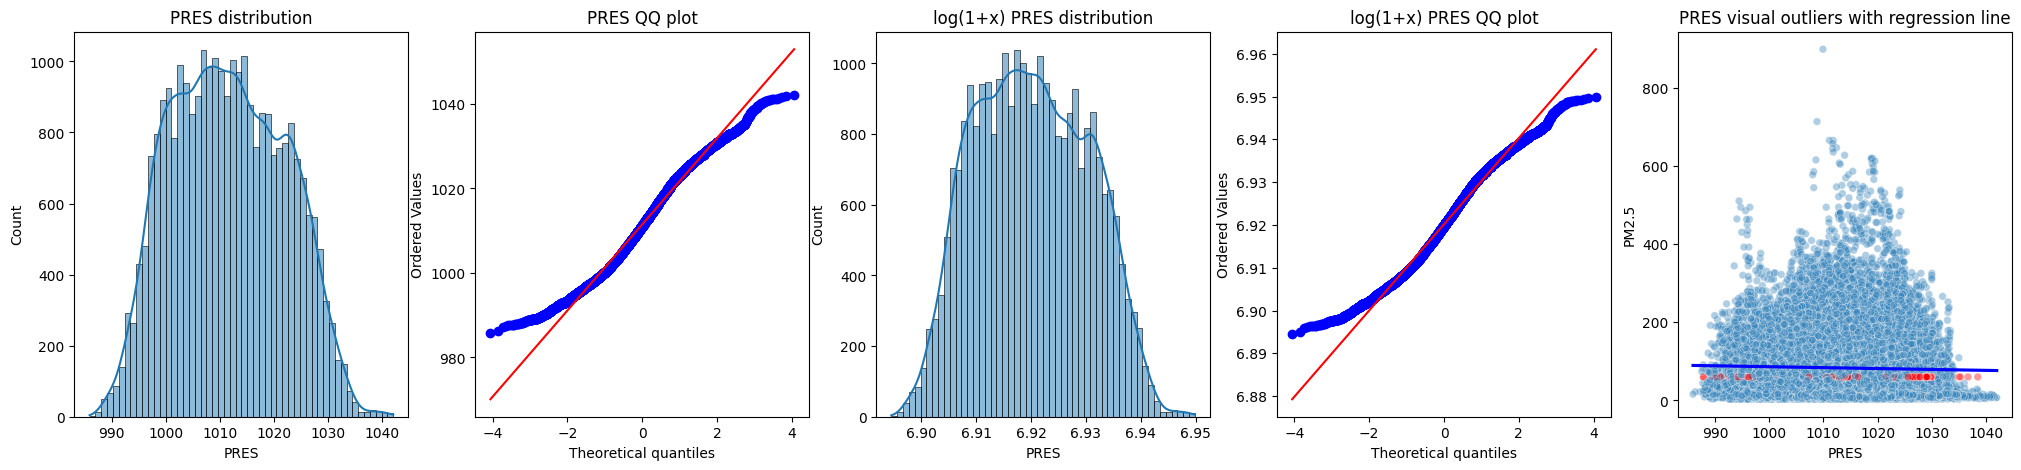

DEWP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


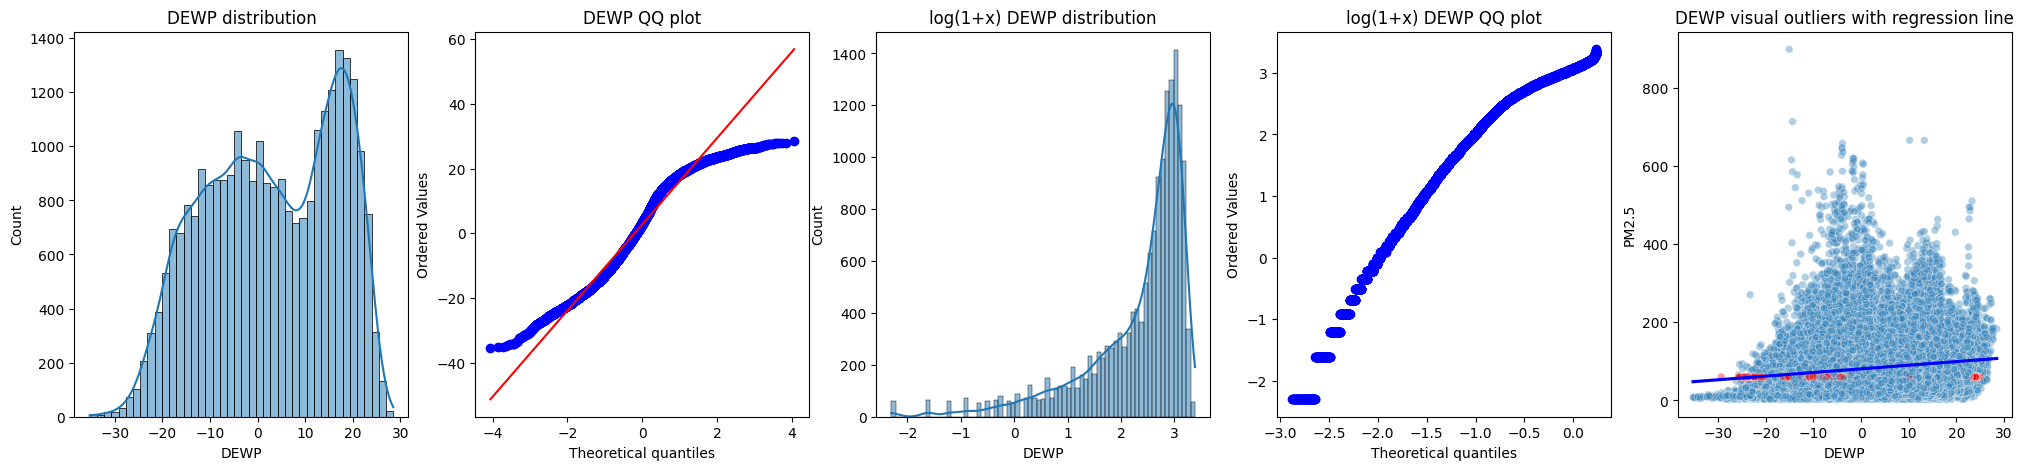

RAIN


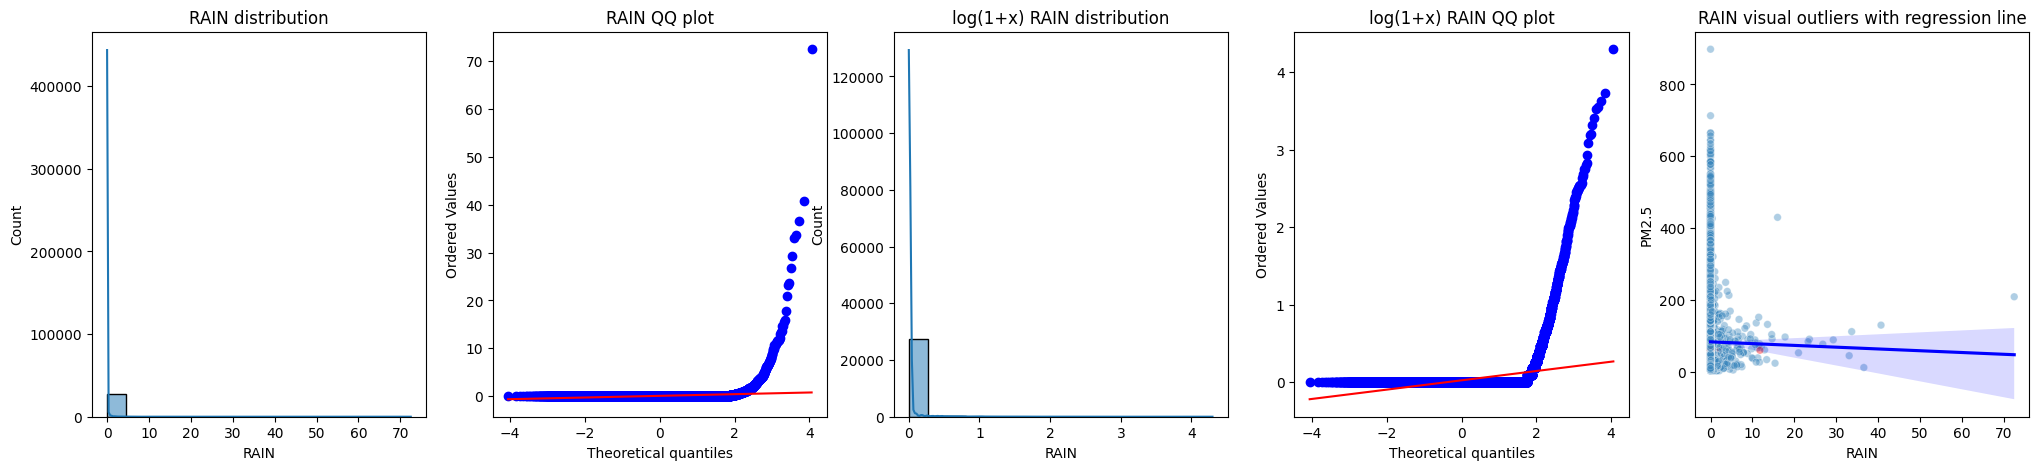

WSPM


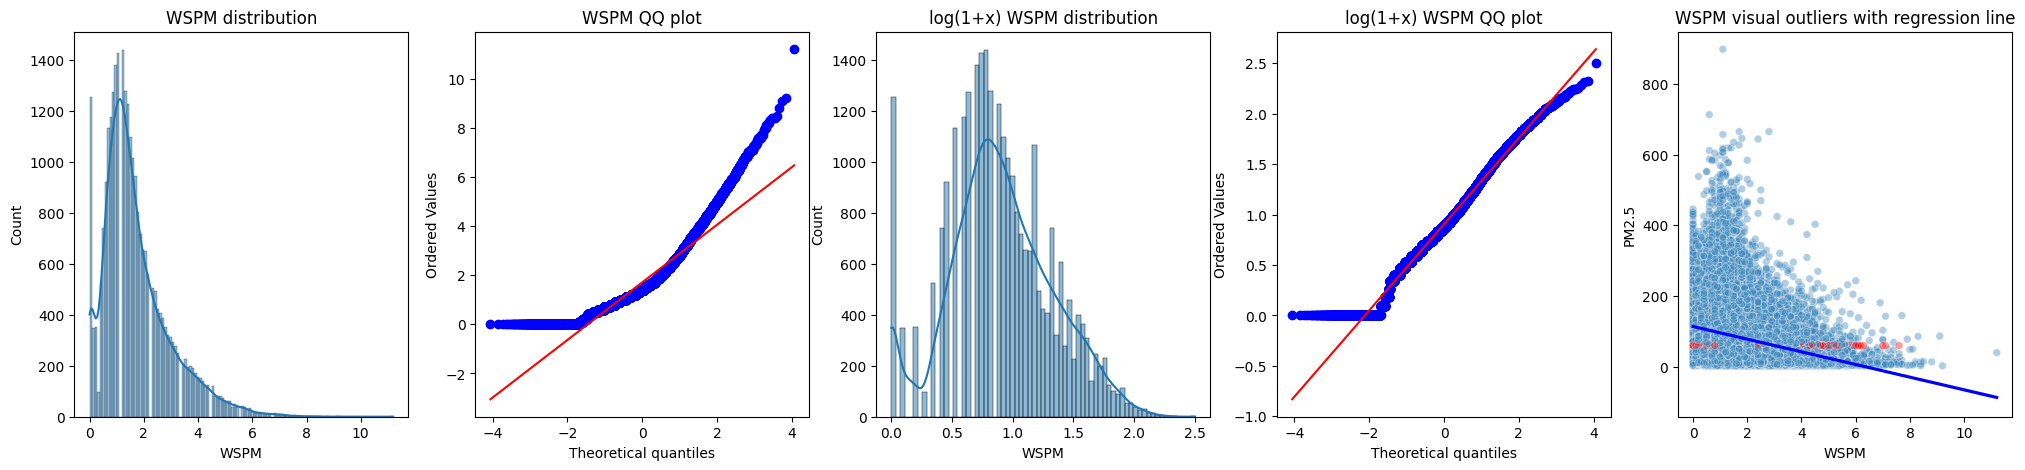

In [26]:
plot_the_features_against_target(df_train_imputed, numerical_features, TARGET, imputed_masks=imputed_masks)

- `PM2.5` (target) - close to normal after the transformation; right-skewed. There a lot of missing values + outliers.
- `PM10` - close to normal after the transformation; right-skewed.
- `SO2` - exponential with a right skew.
- `NO2` - close to normal after the transformation; right-skewed.
- `CO` - close to normal after the transformation; right-skewed.
- `O3` - bimodal. 
- `TEMP` - bimodal.
- `PRES` - close to normal (minimal skewness).
- `DEWP` - bimodal. 
- `RAIN` - exponential. 
- `WSPM` - close to normal after the transformation, right-skewed, has a hint of bimodality.

Outliers are present, including the extreme ones. Distributions are mainly either shifted or heavily skewed. Most features approach normality after the log transformations.

We cannot reliably proceed to null imputation until at least the extreme outliers are dealt with.

## Capping extreme outliers

Since we may not drop outliers in time series analysis and we want to preserve as much data anyway, we need to take a different strategy. The presence of outliers in this domain can be explained by human mistakes, glitched sensors or other anomalies. The tendency of their missingness mostly lies at high target values and only in the columns that reflect chemical composition of pollution mechanisms (mostly, but not entirely), which also confirms the hypothesis about sensors' read-offs.

As we have established, it is a practical phenomena that can and likely will happen in the future, the strategy of capping outliers should be applied therefore. The appropriate strategy for this is `winsorization`. It preserves the natural extreme structure and mitigates severe outlier influence. 

<Axes: >

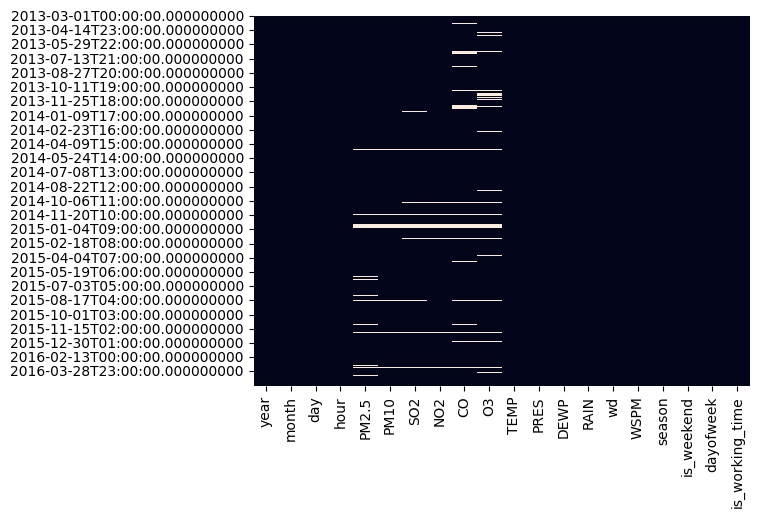

In [27]:
sns.heatmap(df_train.isna(), cbar=False)

### Winsorization

Based on the null columns, we create a dictionary with lower and upper bounds for winsorizing. By assessing percentage, quantity and visual component, we manually adjust the thresholds to cap the extremes.

In [28]:
to_winsorize = {
    'PM10': (0.00001, 0.001), 
    'SO2': (0.00001, 0.001), 
    'NO2': (0.00001, 0.001),
    'CO': (0.00001, 0.001),
    'O3': (0.00001, 0.001),
    'PM2.5': (0.00001, 0.0001),
    'TEMP': (0.001, 0.0005), 
    'PRES': (0.0001, 0.001), 
    'DEWP': (0.001, 0.0008), 
    'RAIN': (0.00001, 0.001), 
    'WSPM': (0.00001, 0.0001), 
}

winsorized_masks = pick_winsorization_thresholds(df_train, to_winsorize)

0.10% (28 upper and 0 lower) of PM10 would be capped
0.10% (27 upper and 0 lower) of SO2 would be capped
0.10% (28 upper and 0 lower) of NO2 would be capped
0.09% (24 upper and 0 lower) of CO would be capped
0.10% (27 upper and 0 lower) of O3 would be capped
0.01% (2 upper and 0 lower) of PM2.5 would be capped
0.16% (15 upper and 29 lower) of TEMP would be capped
0.11% (28 upper and 3 lower) of PRES would be capped
0.18% (22 upper and 29 lower) of DEWP would be capped
0.10% (28 upper and 0 lower) of RAIN would be capped
0.01% (3 upper and 0 lower) of WSPM would be capped


PM10


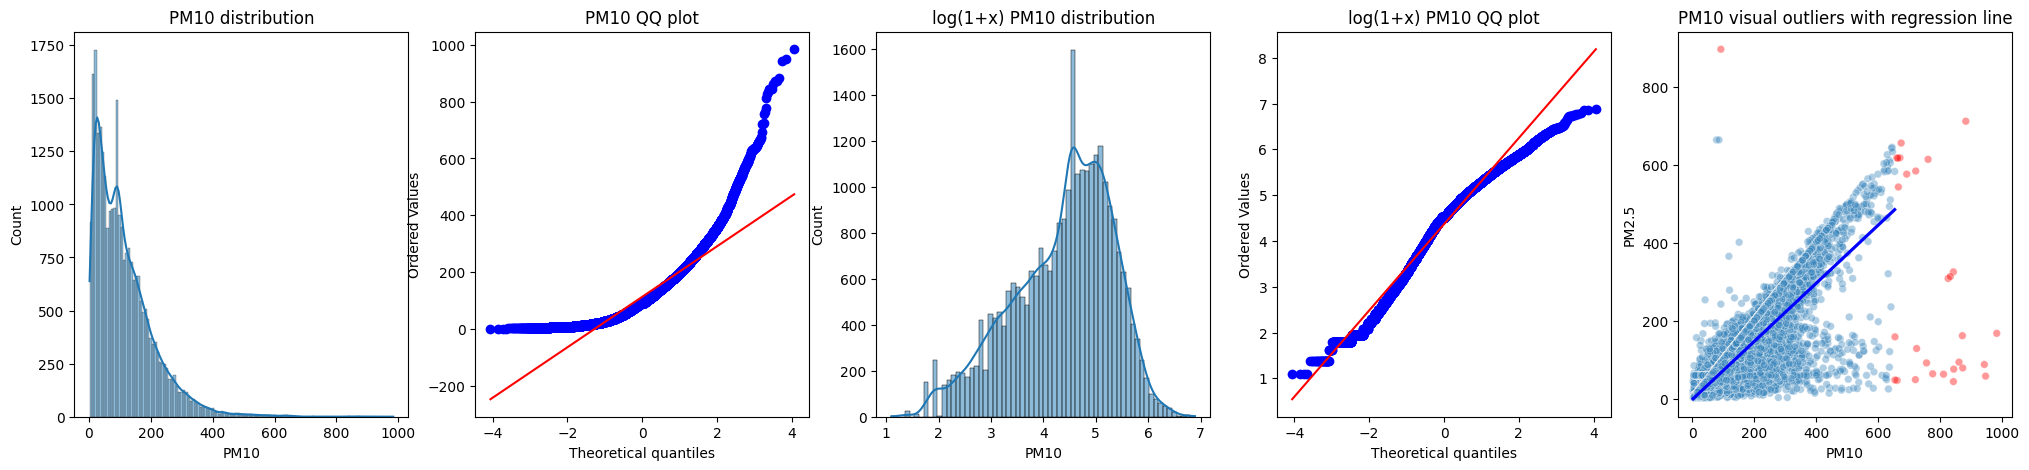

SO2


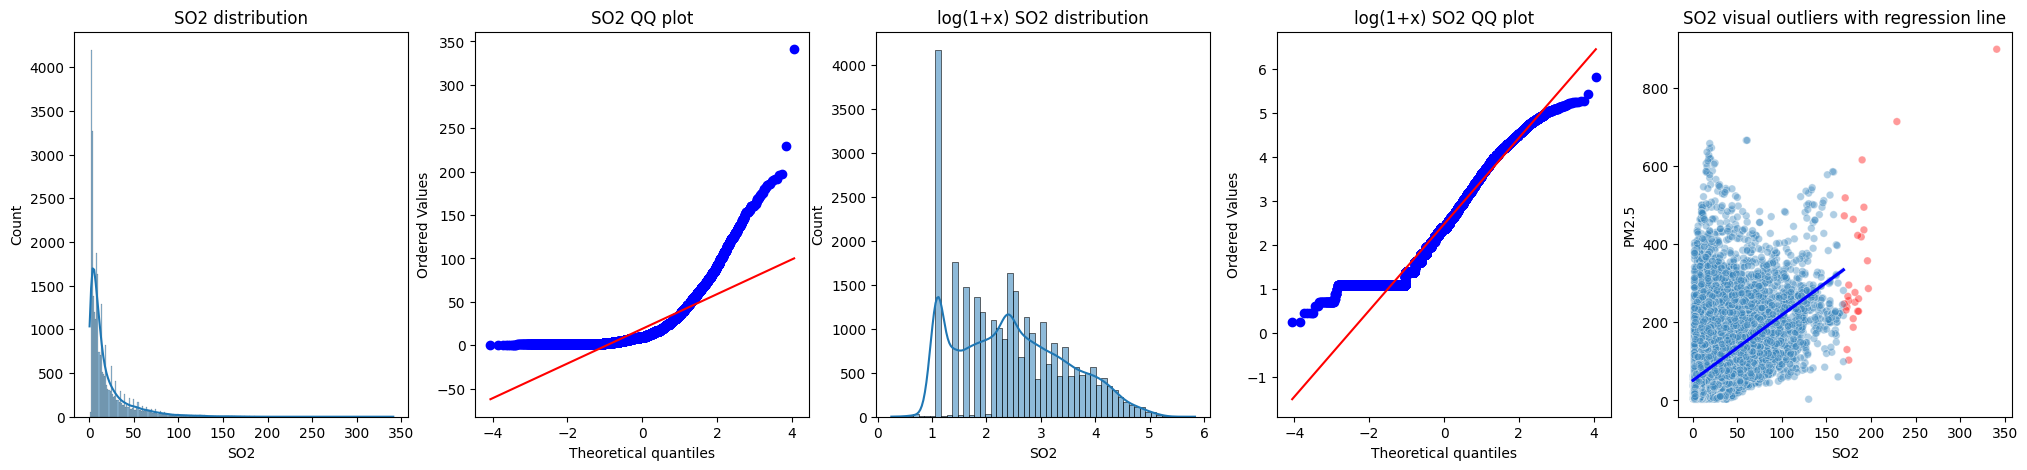

NO2


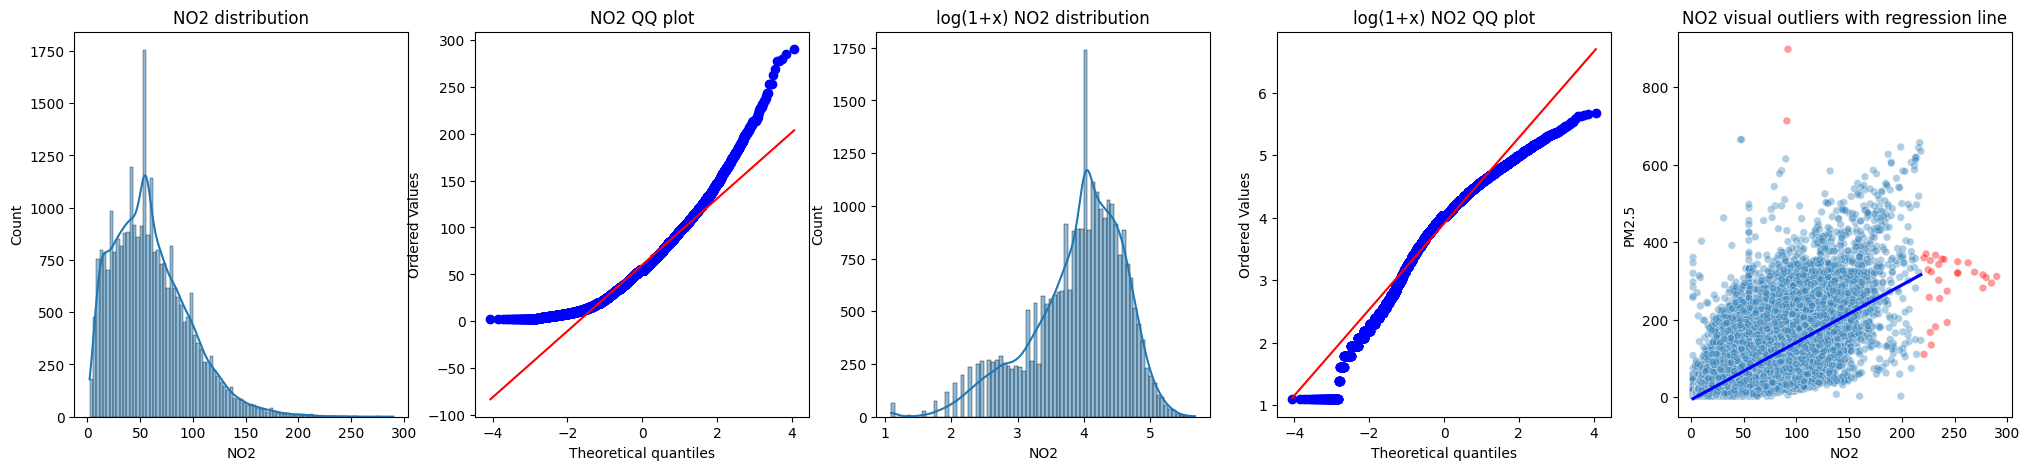

CO


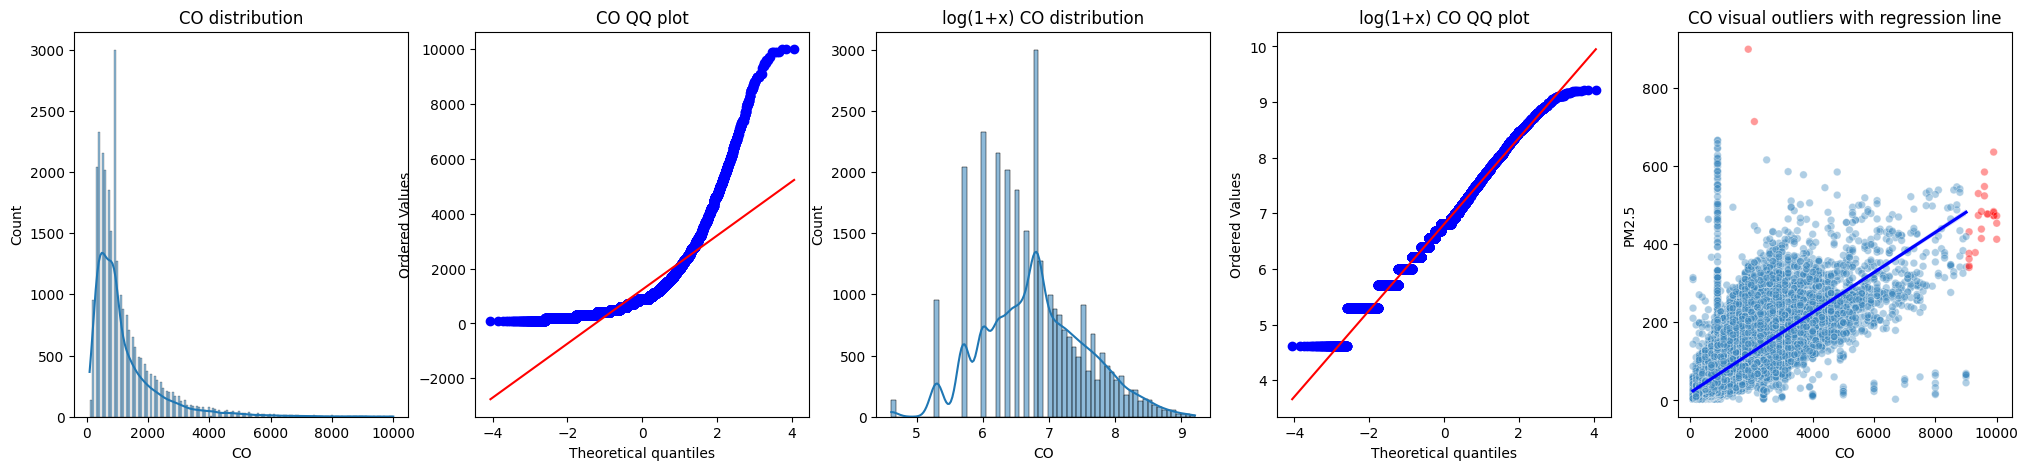

O3


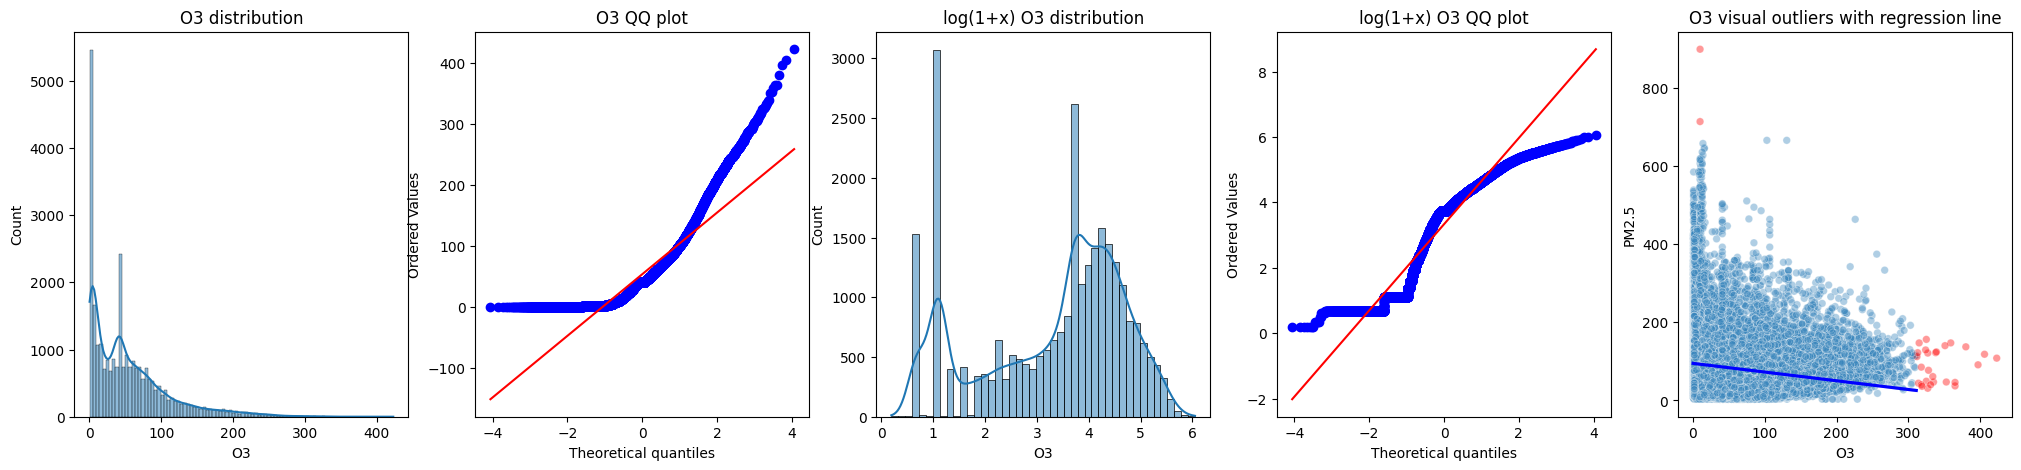

PM2.5


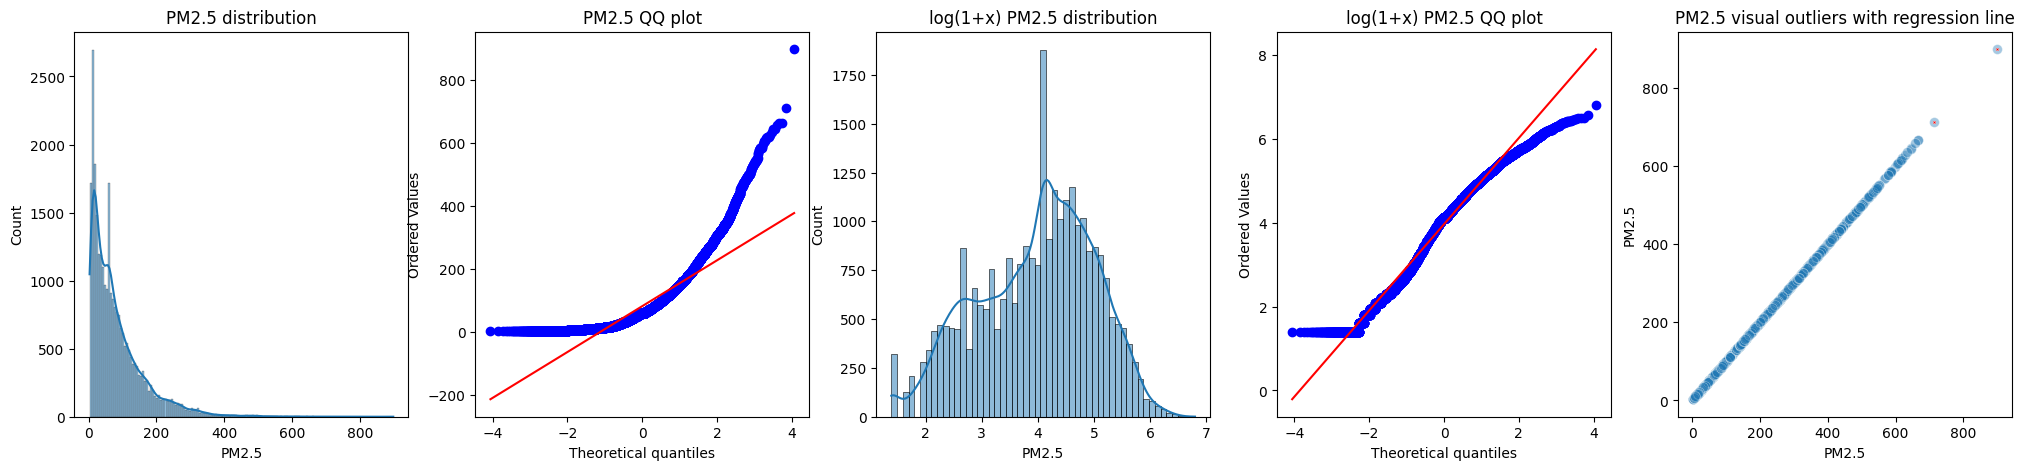

TEMP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


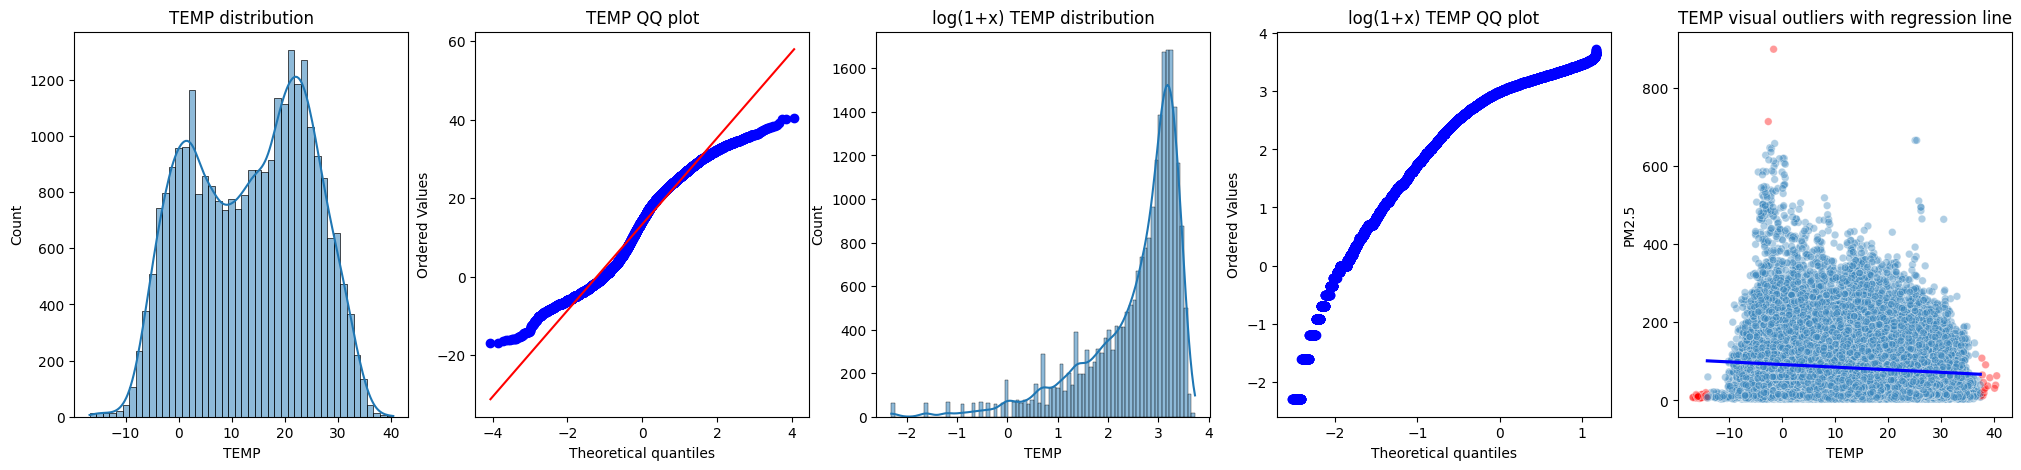

PRES


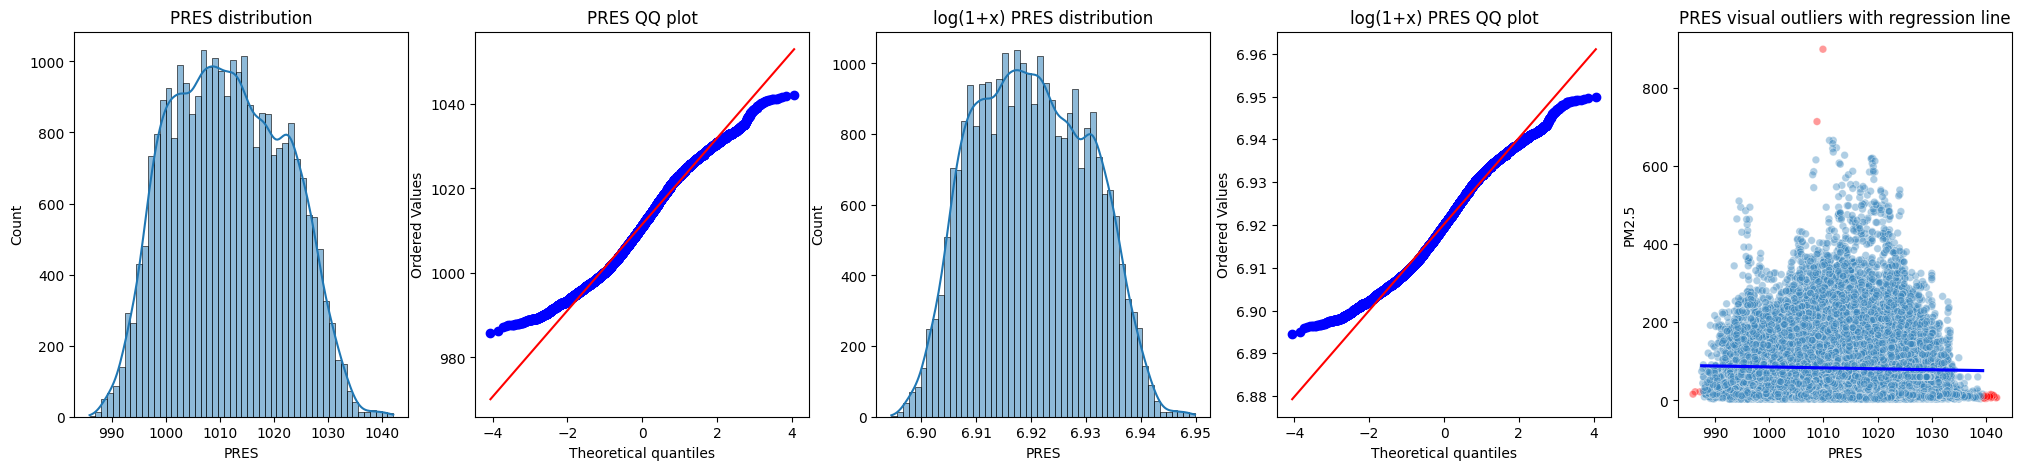

DEWP


c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


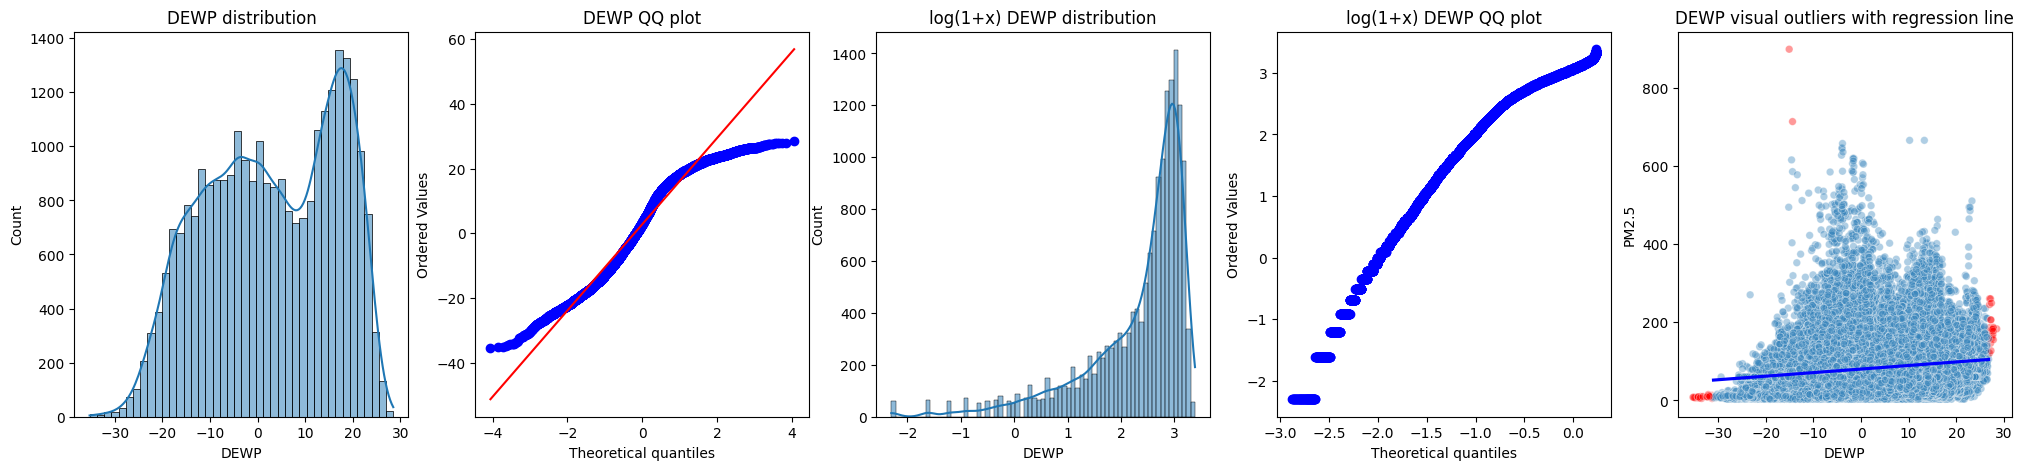

RAIN


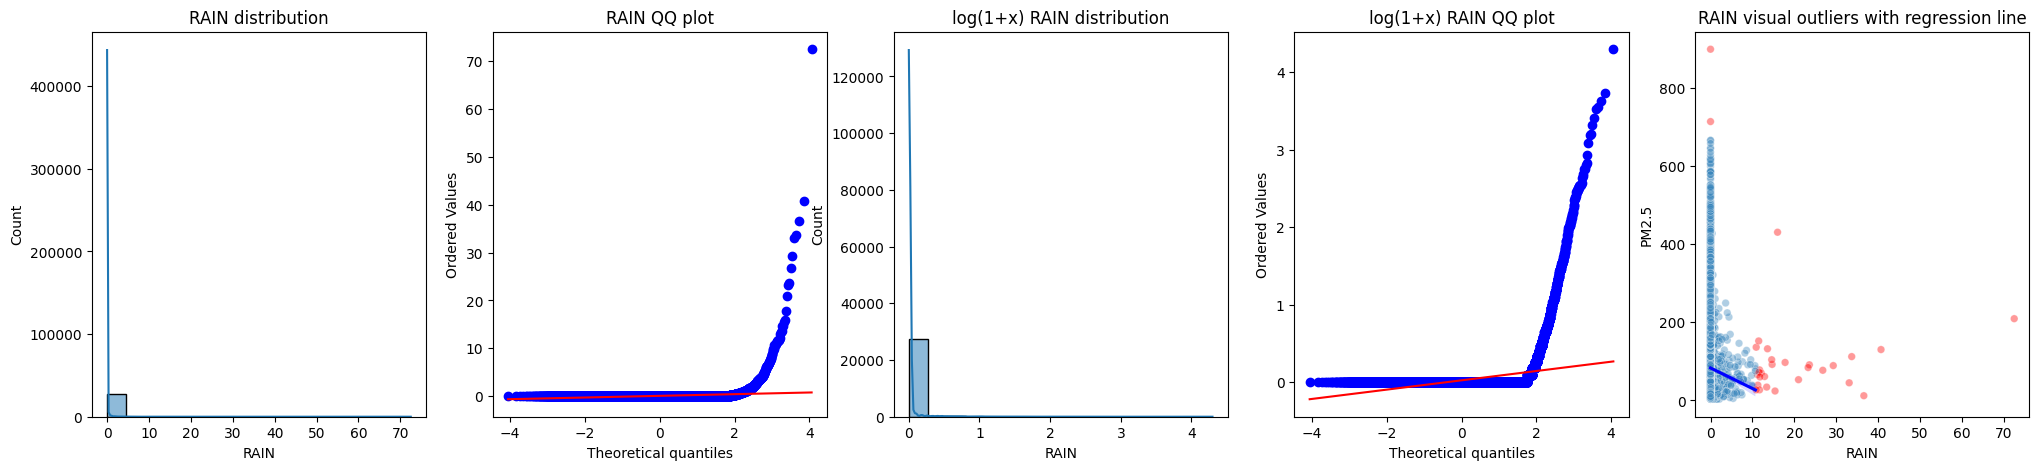

WSPM


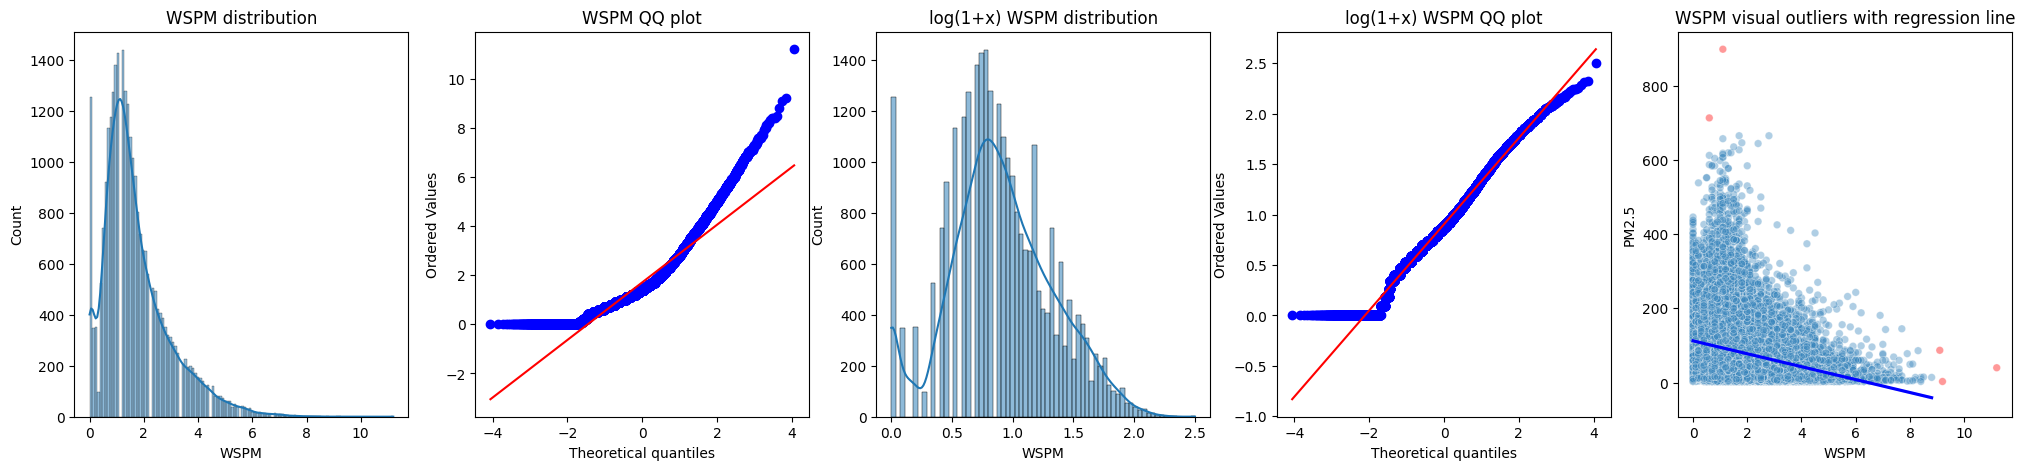

In [29]:
plot_the_features_against_target(df_train_imputed, 
                                 to_winsorize.keys(), 
                                 TARGET, 
                                 imputed_masks=winsorized_masks)

In [30]:
# calculate the quantiles based on the estimated boundaries
winsor_limits = {}
for feat, (low_q, high_q) in to_winsorize.items():
    X = df_train[feat]
    lower = X.quantile(low_q)
    upper = X.quantile(1 - high_q)
    winsor_limits[feat] = (lower, upper)

# apply using fixed values
for feat, (lower, upper) in winsor_limits.items():
    df_train[feat] = df_train[feat].clip(lower, upper)
    df_test[feat] = df_test[feat].clip(lower, upper)

## Column classification consistency

To ensure consistency across all methods to be used on the datasets, the extraction of all columns must be performed once to consistently pass them to different classifiers and methods, also to preserve the order. They will be changing throughout the project, but the main idea is to understand their nature now.

In order to classify the data into categorical (nominal, ordinal) and numerical, we must first resolve the cyclical by encoding them to account for illogical (from the models' perspective) distances, e.x., days 1..28/29/30/31 where the distance between 1 and 31 differs from 31 and 1 (numerically, but not factually).

### Categorical encoding

To know how to deal with the categorical, we are looking into each one.

#### Nominal categorical

We have the only one - `wd`.

count      %
wd                
NE   4010.0  14.30
ENE  3182.0  11.35
SW   2717.0   9.69
NNE  2065.0   7.36
E    1999.0   7.13
WSW  1930.0   6.88
N    1808.0   6.45
SSW  1688.0   6.02
NW   1400.0   4.99
NNW  1307.0   4.66
ESE  1275.0   4.55
W    1027.0   3.66
S     983.0   3.51
WNW   944.0   3.37
SE    936.0   3.34
SSE   769.0   2.74
NaN    11.0   0.04

----------------------------


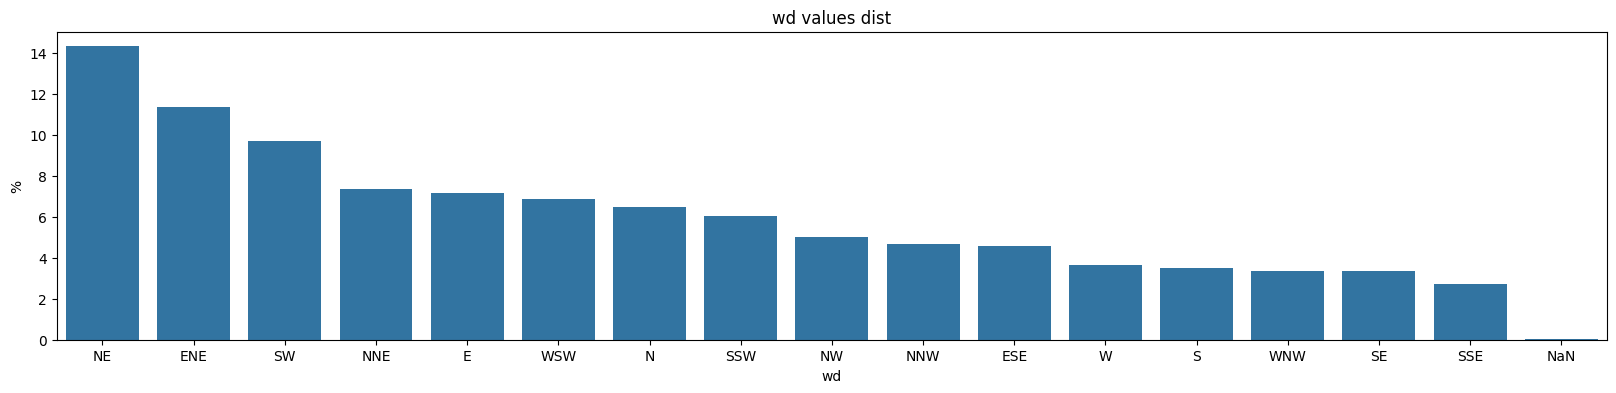

In [31]:
get_categoric_info(df_train, 'wd')

`wd` is circular, typically measured in 16 compass points. We can bin them into 8 primary compass directions for better interpretability and dimensionality reduction + to account for the imbalanced distribution.

##### Binning

In [32]:
bin_map = {
    'N': 'N', 'NNE': 'N', 'NNW': 'N',
    'NE': 'NE', 'ENE': 'NE',
    'E': 'E', 'ESE': 'E',
    'SE': 'SE', 'SSE': 'SE',
    'S': 'S', 'SSW': 'S',
    'SW': 'SW', 'WSW': 'SW',
    'W': 'W', 'WNW': 'W',
    'NW': 'NW'
}

df_train['wd_binned'] = df_train['wd'].map(bin_map)
df_test['wd_binned'] = df_test['wd'].map(bin_map)

display(df_train[['wd', 'wd_binned']].tail())

# drop the original column to prevent multicollinearity
df_train = df_train.drop(columns=['wd'])
df_test = df_test.drop(columns=['wd'])

wd wd_binned
2016-05-12 14:00:00   NW        NW
2016-05-12 15:00:00   NW        NW
2016-05-12 16:00:00  NNW         N
2016-05-12 17:00:00    N         N
2016-05-12 18:00:00  NNW         N

### Ordinal categorical

`is_working_time` is ordinal, already encoded.

### Cyclical categorical

In [ ]:
def encode_cyclical_features(dataframe: pd.DataFrame):
    df_index = pd.to_datetime(dataframe.index)

    dataframe['hour_sin'] = np.sin(2 * np.pi * df_index.hour / 24)
    dataframe['hour_cos'] = np.cos(2 * np.pi * df_index.hour / 24)

    dataframe['month_sin'] = np.sin(2 * np.pi * df_index.month / 12)
    dataframe['month_cos'] = np.cos(2 * np.pi * df_index.month / 12)

    day_of_month = df_index.day                    # 1..28/29/30/31
    days_in_month = df_index.days_in_month        # 28..31
    # avoid division by zero if single-day month (theoretically impossible), use days_in_month - 1 for range
    day_fraction = (day_of_month - 1) / (days_in_month - 1)   # 0.0 .. 1.0

    dataframe["day_sin"] = np.sin(2 * np.pi * day_fraction)
    dataframe["day_cos"] = np.cos(2 * np.pi * day_fraction)

    dataframe['dayofweek_sin'] = np.sin(2 * np.pi * dataframe['dayofweek'] / 7)
    dataframe['dayofweek_cos'] = np.cos(2 * np.pi * dataframe['dayofweek'] / 7)

    # Due to its circular nature, it's closer to nominal than ordinal. It is directional, we are representing it in degrees (0-360):
    direction_map = {
        'N': 0, 'NE': 45, 'E': 90, 'SE': 135, 'S': 180,
        'SW': 225, 'W': 270, 'NW': 315
    }

    dataframe['wd_deg'] = dataframe['wd_binned'].map(direction_map)


    dataframe.drop(columns=["hour", "day", "month", "dayofweek"], inplace=True)

In [34]:
encode_cyclical_features(df_train)
display(df_train.head(2))

encode_cyclical_features(df_test)
display(df_test.head(2))

year  PM2.5  PM10  SO2  NO2     CO    O3  TEMP    PRES  \
2013-03-01 00:00:00  2013    4.0   4.0  4.0  7.0  300.0  77.0  -0.7  1023.0   
2013-03-01 01:00:00  2013    8.0   8.0  4.0  7.0  300.0  77.0  -1.1  1023.2   

                     DEWP  ...  wd_binned  hour_sin  hour_cos  month_sin  \
2013-03-01 00:00:00 -18.8  ...          N  0.000000  1.000000        1.0   
2013-03-01 01:00:00 -18.2  ...          N  0.258819  0.965926        1.0   

                        month_cos day_sin  day_cos  dayofweek_sin  \
2013-03-01 00:00:00  6.123234e-17     0.0      1.0      -0.433884   
2013-03-01 01:00:00  6.123234e-17     0.0      1.0      -0.433884   

                     dayofweek_cos  wd_deg  
2013-03-01 00:00:00      -0.900969     0.0  
2013-03-01 01:00:00      -0.900969     0.0  

[2 rows x 25 columns]

year  PM2.5  PM10  SO2   NO2     CO    O3  TEMP    PRES  \
2016-05-12 19:00:00  2016   10.0  36.0  2.0  18.0  300.0  89.0  20.3  1011.7   
2016-05-12 20:00:00  2016   26.0  52.0  2.0  30.0  400.0  66.0  17.4  1012.6   

                     DEWP  ...  wd_binned  hour_sin  hour_cos  month_sin  \
2016-05-12 19:00:00  -5.6  ...          N -0.965926  0.258819        0.5   
2016-05-12 20:00:00   0.1  ...          N -0.866025  0.500000        0.5   

                     month_cos   day_sin   day_cos  dayofweek_sin  \
2016-05-12 19:00:00  -0.866025  0.743145 -0.669131       0.433884   
2016-05-12 20:00:00  -0.866025  0.743145 -0.669131       0.433884   

                     dayofweek_cos  wd_deg  
2016-05-12 19:00:00      -0.900969     0.0  
2016-05-12 20:00:00      -0.900969     0.0  

[2 rows x 25 columns]

### Classifying the features

In [35]:
all_features = df_train.columns.tolist()
ordinal_categorical_cols = ['is_working_time', 'season', 'is_weekend']
nominal_categorical_cols = ['wd_binned']

numerical_cols = df_train\
    .drop(columns=ordinal_categorical_cols + nominal_categorical_cols + [TARGET])\
    .select_dtypes(include="number").columns.tolist()

print(f"All columns ({len(all_features)}): {all_features} \n")
print(f"ordinal categorical columns ({len(ordinal_categorical_cols)}): {ordinal_categorical_cols}")
print(f"numerical columns({len(numerical_cols)}): {numerical_cols})")
print(f"nominal categorical columns ({len(nominal_categorical_cols)}): {nominal_categorical_cols}\n")
print(f"All columns classified? Classified: {len(ordinal_categorical_cols)+len(numerical_cols)+len(nominal_categorical_cols)}/{len(all_features)-1}") # '-1' to account for target
print(f"Columns not classified (should be only target): {set(all_features).symmetric_difference(set(ordinal_categorical_cols+nominal_categorical_cols+numerical_cols))}")

All columns (25): ['year', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'season', 'is_weekend', 'is_working_time', 'wd_binned', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'wd_deg'] 

ordinal categorical columns (3): ['is_working_time', 'season', 'is_weekend']
numerical columns(20): ['year', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'wd_deg'])
nominal categorical columns (1): ['wd_binned']

All columns classified? Classified: 24/24
Columns not classified (should be only target): {'PM2.5'}


In [ ]:
def preprocess(df_tr, df_te, target: str,
               numerical_cols, categoric_nominal_cols, categoric_ordinal_cols,
               to_scale=True, drop_first=True, fill_na=True):
    
    scaler_df = None
    # convert arrays to numpy
    X_numerical_cols = np.array(numerical_cols)
    X_categoric_nominal_cols = np.array(categoric_nominal_cols)
    X_categoric_ordinal_cols = np.array(categoric_ordinal_cols)

    ytr_prepared = df_tr[target]
    yte_prepared = df_te[target]
    
    # ensure target not in feature arrays
    X_numerical_cols = X_numerical_cols[X_numerical_cols != target]
    X_categoric_nominal_cols = X_categoric_nominal_cols[X_categoric_nominal_cols != target]
    X_categoric_ordinal_cols = X_categoric_ordinal_cols[X_categoric_ordinal_cols != target]

    if target not in df_tr.columns:
        print(f"{target} wasn't found in train df, please add it")
        return
    if target not in df_te.columns:
        print(f"{target} wasn't found in test df, please add it")
        return

    # --- NUMERIC
    Xtr_num = df_tr[X_numerical_cols]
    Xte_num = df_te[X_numerical_cols]
    if fill_na:
        train_medians = Xtr_num.median()
        Xtr_num = Xtr_num.fillna(train_medians)
        Xte_num = Xte_num.fillna(train_medians)

    if to_scale:
        scaler = StandardScaler().fit(Xtr_num)
        scaler_df = pd.DataFrame({'col': numerical_cols, 'std': scaler.scale_})
        Xtr_num = pd.DataFrame(scaler.transform(Xtr_num), columns=numerical_cols, index=Xtr_num.index)
        Xte_num = pd.DataFrame(scaler.transform(Xte_num), columns=numerical_cols, index=Xte_num.index)

    # --- CATEGORICAL
    X_cat_columns = np.append(X_categoric_nominal_cols, X_categoric_ordinal_cols)
    Xtr_cat = df_tr[X_cat_columns].copy()
    Xte_cat = df_te[X_cat_columns].copy()
    if fill_na:
        train_modes = Xtr_cat.mode().iloc[0]
        Xtr_cat = Xtr_cat.fillna(train_modes)
        Xte_cat = Xte_cat.fillna(train_modes)

    Xtr_cat_dummies = pd.get_dummies(Xtr_cat[X_categoric_nominal_cols], drop_first=drop_first, dtype=float)
    Xte_cat_dummies = pd.get_dummies(Xte_cat[X_categoric_nominal_cols], drop_first=drop_first, dtype=float)
    Xte_cat_dummies = Xte_cat_dummies.reindex(columns=Xtr_cat_dummies.columns, fill_value=0.0)

    # --- combine final
    Xtr_prepared = pd.concat([Xtr_num, Xtr_cat_dummies, Xtr_cat[X_categoric_ordinal_cols]], axis=1)
    Xte_prepared = pd.concat([Xte_num, Xte_cat_dummies, Xte_cat[X_categoric_ordinal_cols]], axis=1)
    Xte_prepared = Xte_prepared.reindex(columns=Xtr_prepared.columns, fill_value=0.0)

    return Xtr_prepared, Xte_prepared, ytr_prepared, yte_prepared, scaler_df

In [ ]:
# preprocess the data (encode dummies; scale/fillna if needed)
X_df_train, X_df_test, \
y_df_train, y_df_test, \
scaler_df = preprocess(df_train, df_test, TARGET, 
                    numerical_cols, nominal_categorical_cols, ordinal_categorical_cols,
                    to_scale=False, drop_first=True, fill_na=False)

In [38]:
print("X_df_train:")
display(X_df_train.head(1))

print("X_df_test:")
display(X_df_test.head(1))

X_df_train:


year  PM10  SO2  NO2     CO    O3  TEMP    PRES  DEWP  RAIN  ...  \
2013-03-01  2013   4.0  4.0  7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  ...   

            wd_binned_N  wd_binned_NE  wd_binned_NW  wd_binned_S  \
2013-03-01          1.0           0.0           0.0          0.0   

            wd_binned_SE  wd_binned_SW  wd_binned_W  is_working_time  season  \
2013-03-01           0.0           0.0          0.0                0       2   

            is_weekend  
2013-03-01           0  

[1 rows x 30 columns]

X_df_test:


year  PM10  SO2   NO2     CO    O3  TEMP    PRES  DEWP  \
2016-05-12 19:00:00  2016  36.0  2.0  18.0  300.0  89.0  20.3  1011.7  -5.6   

                     RAIN  ...  wd_binned_N  wd_binned_NE  wd_binned_NW  \
2016-05-12 19:00:00   0.0  ...          1.0           0.0           0.0   

                     wd_binned_S  wd_binned_SE  wd_binned_SW  wd_binned_W  \
2016-05-12 19:00:00          0.0           0.0           0.0          0.0   

                     is_working_time  season  is_weekend  
2016-05-12 19:00:00                0       2           0  

[1 rows x 30 columns]

In [39]:
df_train = pd.concat([X_df_train, y_df_train], axis=1)
df_test = pd.concat([X_df_test, y_df_test], axis=1)

## Save the data

In [40]:
df_train.to_csv(os.path.join(data_folder_path, 'processed', "01_df_train_preprocessed.csv"), index=True, index_label='datetime')
df_test.to_csv(os.path.join(data_folder_path, 'processed', "01_df_test_preprocessed.csv"), index=True, index_label='datetime')